In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn import metrics

from sqlalchemy import create_engine
import datetime 
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib
from TurbineTimeSeries.storage import MachineDataStore
from TurbineTimeSeries.transformations import StepSize, PowerStepSize

In [2]:
model_number = 2

store = MachineDataStore('.config')

# model_data_hr = (store.query(model_number,'1hr')
#                  .not_null(['timestamp','psn'])
# #                  .exclude_psn([44,52,54,70])
#                  .execute())

model_data_min = (store.query(model_number,'10min')
                  .not_null(['timestamp','psn'])
                  .exclude_psn([44,52,54,70])
                  .execute())

model_data_min.head()

/Users/jillianjarrett/anaconda2/envs/py36envir/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


SELECT * FROM sensor_readings_model2_10min WHERE timestamp IS NOT NULL AND psn IS NOT NULL AND psn not in (44,52,54,70)


id  lo_c_dp1   f_c_dp1   f_c_dp2   f_c_dp5  pe_c_dt1   g_c_dt1  \
0  748834  0.266275  0.069489  0.028374  0.270104  0.257778  0.007999   
1  748835  0.265987  0.083112  0.011345  0.269696  0.252222  0.012002   
2  748836  0.263590  0.096204 -0.005676  0.271058  0.251112  0.016002   
3  748837  0.262392  0.109827 -0.005676  0.270785  0.248890  0.016002   
4  748838  0.263245  0.105286  0.011345  0.270785  0.255554  0.011999   

    g_c_dt2  lo_c_dt5   c_dt5_1 ...     v_d_2b     lo_t5      g_t2    f_t1  \
0  0.165999  0.424705 -0.200000 ...   0.194285  0.760000  0.840000  0.3595   
1  0.142002  0.424707 -0.187334 ...   0.197142  0.759565  0.832572  0.3580   
2  0.154001  0.421177 -0.201833 ...   0.194285  0.758261  0.836000  0.3585   
3  0.151999  0.424707 -0.193834 ...   0.188571  0.759565  0.835428  0.3600   
4  0.150001  0.425882 -0.194666 ...   0.185714  0.761304  0.836572  0.3600   

     sum_enr    g_t3   g_pct1    f_pos1                  timestamp  psn  
0  86.873418  0.4276  0.34244  0.482371 2017-07-03 03:19:59.999998   62  
1  86.907342  0.4336  0.35189  0.483574 2017-07-03 03:30:00.000003   62  
2  86.941013  0.4300  0.36265  0.483574 2017-07-03 03:39:59.999997   62  
3  86.974177  0.4308  0.33308  0.483574 2017-07-03 03:50:00.000002   62  
4  87.007848  0.4300  0.34888  0.483574 2017-07-03 03:59:59.999996   62  

[5 rows x 76 columns]

In [3]:
freq = '10min'
model_data = model_data_min
len(model_data)

1602326

In [4]:
skipped_cols = ['sum_esn','sum_eng_st', 'sum_eng_h']
index_cols = ['id','timestamp','psn']
data_cols = [c for c in model_data.columns if (c not in index_cols) and (c not in skipped_cols)]

In [5]:
missing_values = model_data.isnull().sum().sort_values()
sparse_cols = [x for x in missing_values.index if missing_values[x] > 30000]
clean_data_cols = [x for x in data_cols if x not in sparse_cols]

In [6]:
model_data[model_data['sum_eng_st'].isnull()]

id  lo_c_dp1   f_c_dp1   f_c_dp2   f_c_dp5  pe_c_dt1   g_c_dt1  \
696484  1446076  0.127995  0.014319  0.028381  0.325169  0.568644  0.044003   

         g_c_dt2  lo_c_dt5   c_dt5_1 ...     v_d_2b    lo_t5      g_t2   f_t1  \
696484  0.314003  0.532942  0.053325 ...   0.165714  0.78087  0.857143  0.673   

          sum_enr   g_t3   g_pct1    f_pos1                  timestamp  psn  
696484  71.163864  0.222  0.43811  0.591346 2017-10-31 18:39:59.999997   51  

[1 rows x 76 columns]

In [7]:

data = model_data[index_cols + clean_data_cols].dropna().reset_index()
clean_data = StandardScaler().fit_transform(data[clean_data_cols])

pca =  PCA().fit(clean_data)
reduced = pca.transform(clean_data)

In [8]:
def roundTime(dt=None, roundTo=60):
    """Round a datetime object to any time laps in seconds
    dt : datetime.datetime object, default now.
    roundTo : Closest number of seconds to round to, default 1 minute.
    Author: Thierry Husson 2012 - Use it as you want but don't blame me.
    """
    if dt == None : dt = datetime.datetime.now()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)
n = datetime.datetime(2015,12,5,0,10,0,4)
print(n)
print(roundTime(n,600))

2015-12-05 00:10:00.000004
2015-12-05 00:10:00


In [9]:
reduced_df = pd.DataFrame(reduced)

In [10]:

reduced_df['psn'] = data.psn.values
reduced_df['timestamp'] = data.timestamp.values

#reduced_df.set_index([data.psn.values, data.timestamp.values])

In [11]:
eig_df = reduced_df[['psn','timestamp',0,1,2,3,4,5,6,7,8,9,10]]
eig_df.columns = ['psn','timestamp','eig0','eig1','eig2','eig3','eig4','eig5','eig6','eig7','eig8','eig9','eig10']
eig_df.head()

psn                  timestamp       eig0      eig1      eig2      eig3  \
0   62 2017-07-03 03:19:59.999998  10.874386 -4.582596  0.640216 -0.011155   
1   62 2017-07-03 03:30:00.000003  10.566446 -4.466257  0.471729 -0.082046   
2   62 2017-07-03 03:39:59.999997  10.781455 -4.549097  0.448211 -0.131743   
3   62 2017-07-03 03:50:00.000002  10.577235 -4.609505  0.567070 -0.160696   
4   62 2017-07-03 03:59:59.999996  10.646234 -4.785537  0.351168 -0.387728   

       eig4      eig5      eig6      eig7      eig8      eig9     eig10  
0 -1.099033  0.323496 -2.707881 -2.256011  1.606701  0.093378 -0.298582  
1 -1.311584 -0.124291 -3.036025 -1.830366  1.494335  0.074276 -0.143505  
2 -1.230701 -0.283143 -3.139220 -2.062612  1.515007  0.187542 -0.323860  
3 -1.178241 -0.283500 -2.826825 -1.793481  1.402721  0.192670 -0.098927  
4 -1.198526 -0.479855 -3.468351 -1.612749  1.391862  0.013799 -0.015457

In [12]:
import numpy as np
import pylab

def thresholding_algo(y, lag=20, threshold=20, influence=0):
    """
    lag = the lag of the moving window, 
    threshold = the z-score at which the algorithm signals and 
    influence = the influence (between 0 and 1) of new signals on the mean and standard deviation.
    """
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

/Users/jillianjarrett/anaconda2/envs/py36envir/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/jillianjarrett/anaconda2/envs/py36envir/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


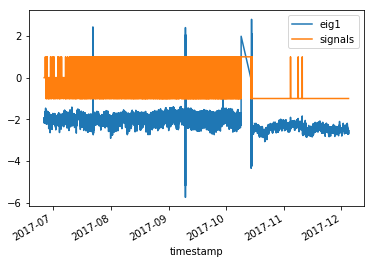

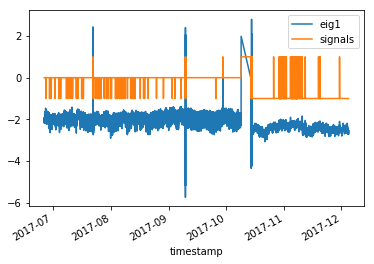

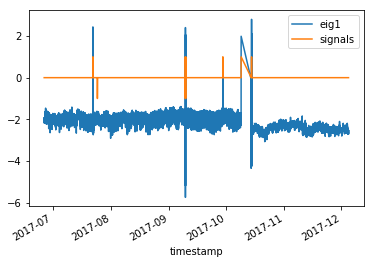

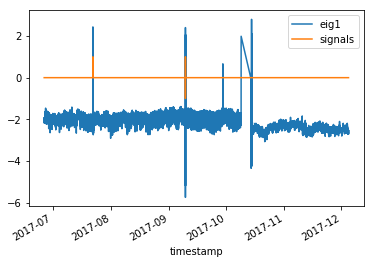

In [13]:
#testing different thresholds
for i in [3,5,10,20]:    
    psn39_signals = thresholding_algo(eig_df[eig_df.psn==39].eig1.values, threshold=i)
    psn39 = eig_df[eig_df.psn==39]
    psn39['signals'] = psn39_signals['signals']
    psn39.plot(y=['eig1','signals'], x = 'timestamp')
    plt.show()

/Users/jillianjarrett/anaconda2/envs/py36envir/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/jillianjarrett/anaconda2/envs/py36envir/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


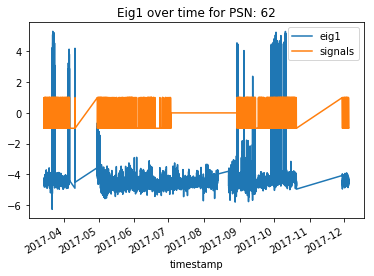

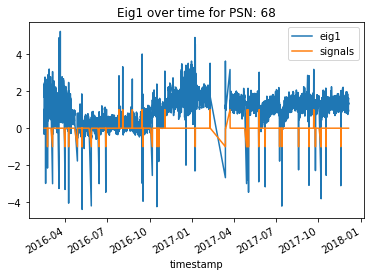

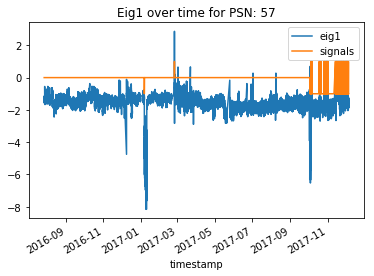

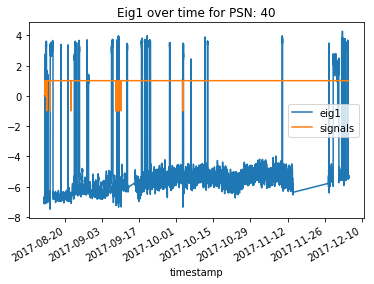

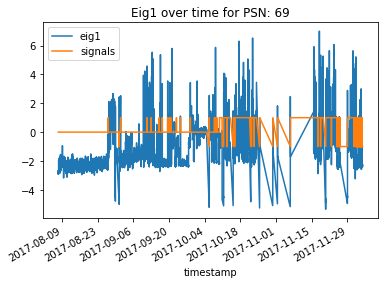

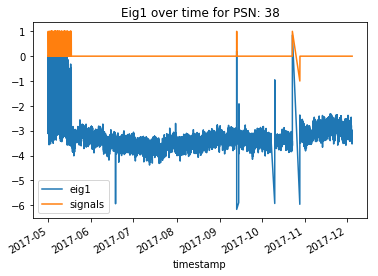

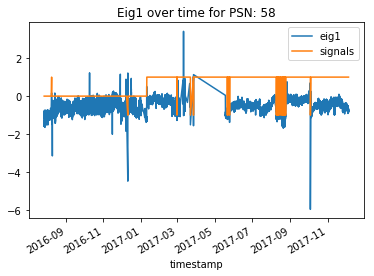

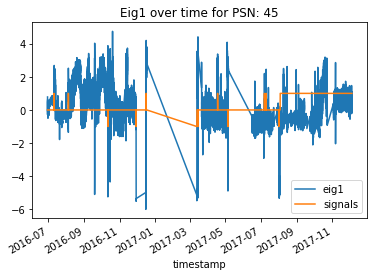

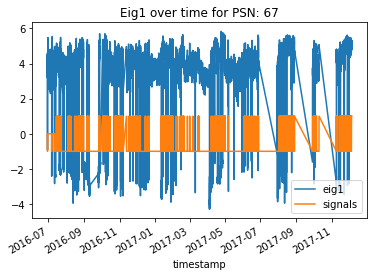

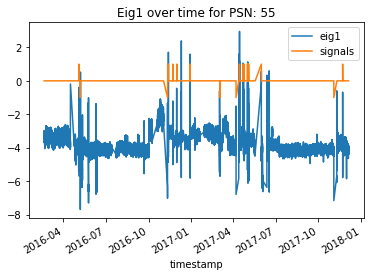

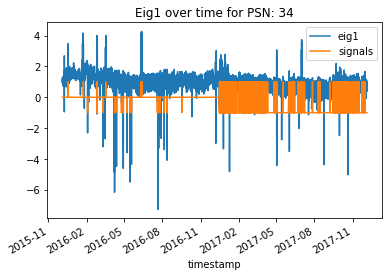

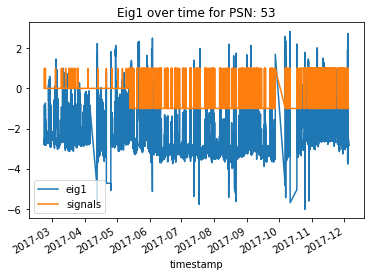

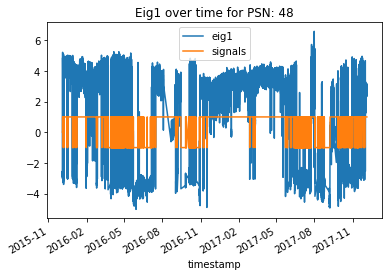

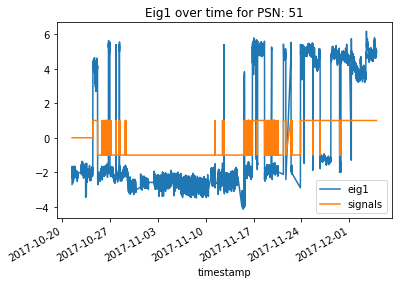

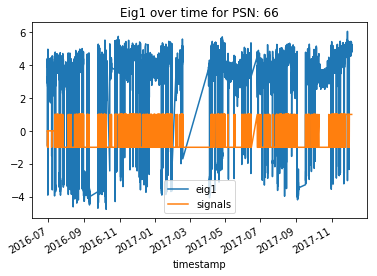

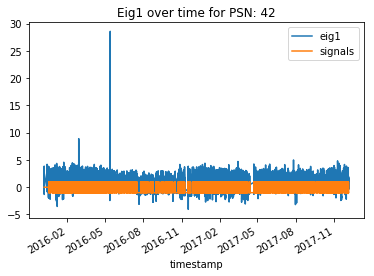

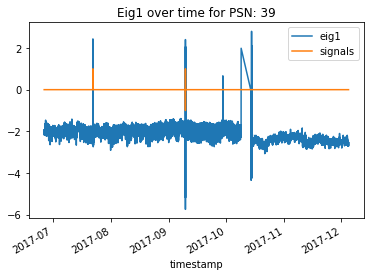

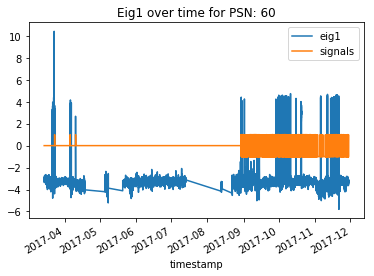

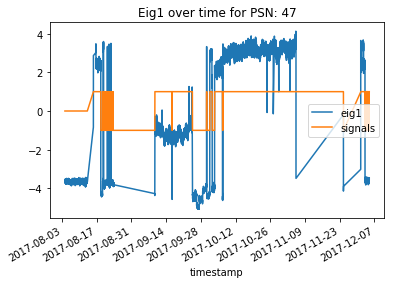

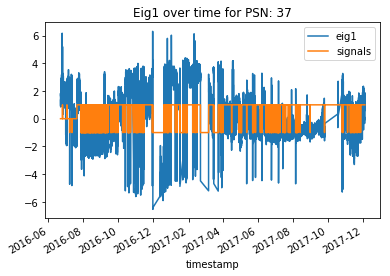

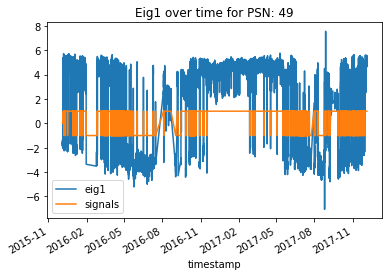

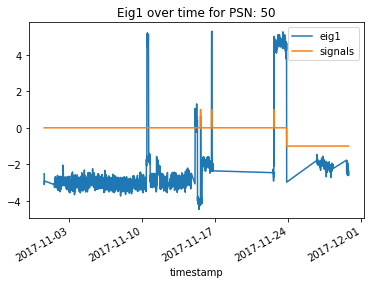

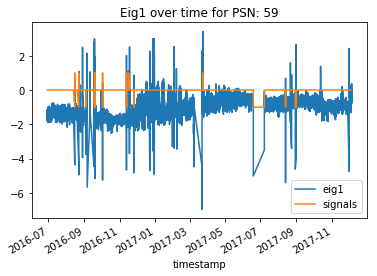

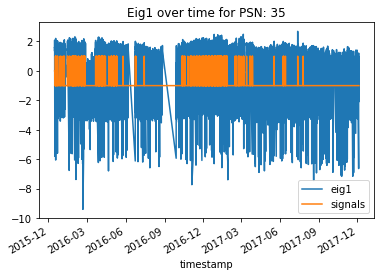

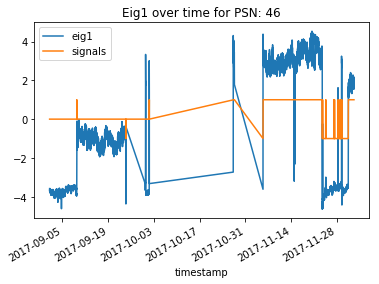

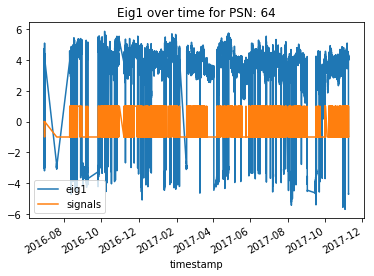

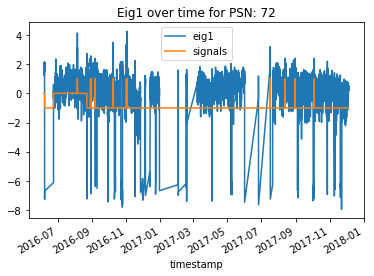

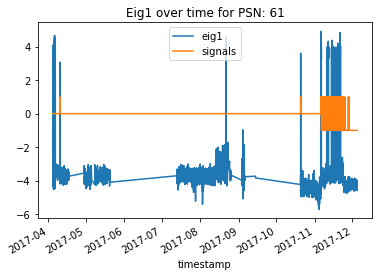

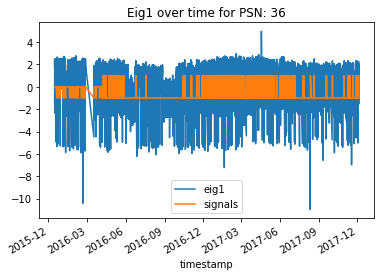

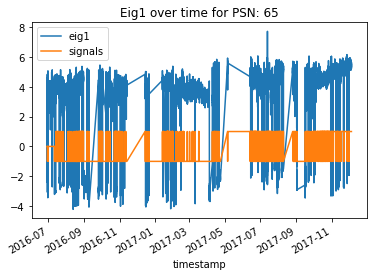

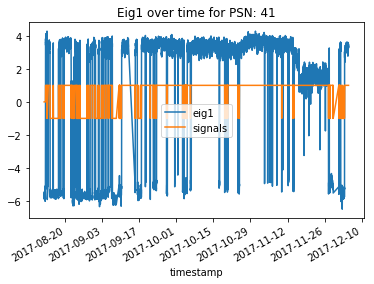

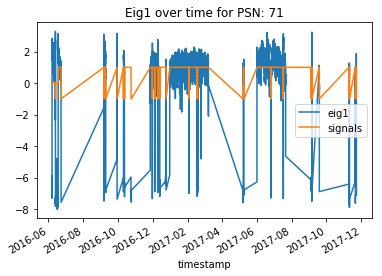

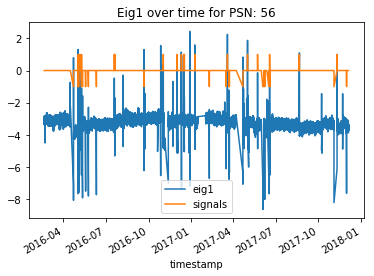

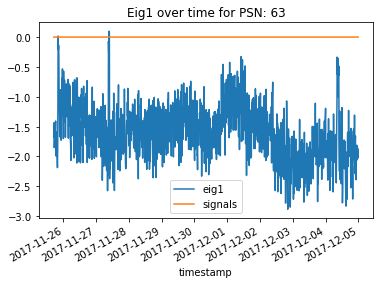

In [14]:
#analyzing thresholding algorithm
for psn in eig_df.psn.unique():
    temp_df = eig_df[eig_df.psn==psn]
    temp_signal_dict = thresholding_algo(temp_df.eig1.values)
    temp_df['signals'] = temp_signal_dict['signals']
    temp_df.plot(y=['eig1','signals'], x = 'timestamp')
    plt.title('Eig1 over time for PSN: '+str(psn))
    plt.show()


In [15]:
def find_power_step (df,powercol,jump = 0.25):
    ## function will return another dataframe where the power columns is replace with 1s and 0s. 1 represents an outlier.
    ## the returned dataframe is also offset by 1 index since we are finding differences in datapoints.
    ## assumes data coming in is sorted by psn by timestamp.

    
    df = df[[powercol,'timestamp','psn']]

    df = df.where((pd.notnull(df)),np.nan) ## replaces nulls with nans for math stuffs.
    df2 = pd.DataFrame(index = df.index.values[1:],columns = df.columns.values)
    df2['timestamp'] = df['timestamp'].values[1:]
    ## np.divide will divide the first parameter by the second parameter so the resulting series starts
    ## from the original dataframe's 1st item, not the 0th item.
#     shifted = pd.Series(np.subtract(df[powercol].values[1:],df[powercol].values[:-1]),index=df.index.values[:-1])

    shifted = pd.Series(np.divide(df[powercol].values[:-1],df[powercol].values[1:]),index=df.index.values[1:])-1

    ## take all values and subtract from previous values. if unchanging, then result will be 0
    ## create numpy array of all False

    tomap = np.zeros(len(df2),dtype=int)  
    
    
    ## find where jumps in data are greater than given jump parameter, and set numpy array equal to True in those positions
    for j in shifted[abs(shifted)>=jump].index.values:
        ## for now just doing where power jumps.
        ## does not catch all in betweens since transients are only 10-20 mins long.
        if (df.loc[j]['timestamp'] - df.loc[j-1]['timestamp']) > pd.Timedelta('12 minutes'): ## if data is not continuous
            continue
                        
        else:
            tomap[j] = True


    
    ## map back numpy array to df2
    df2[powercol] = pd.Series(tomap).loc[1:]

    df2.loc[0] = [0,df.loc[0]['timestamp'],0] ## assume not outlier for row 0. this also 0-indexes the dataframe again
    df2 = df2.sort_index()
    df2['psn'] = df['psn']
    return(df2)

In [16]:
#testing power_step on reduced and raw data
temp= find_power_step(psn39,'eig1')
temp['eig1_data']=psn39.eig1.values
temp.plot(x='timestamp',y=['eig1_data','eig1'])
plt.show()

pow_temp = find_power_step(data[data.psn==39], 'perf_pow')
pow_temp['perf_raw'] = data[data.psn==39]['perf_pow']
pow_temp.plot(x='timestamp',y=['perf_raw','perf_pow'])
plt.show()

IndexError: index 856116 is out of bounds for axis 0 with size 22332

In [17]:
#changed stepsize fn to have dynamic rolling avg

def efficient_stepsize (inputdf,ignore_columns=None,threshold = 3,rolling_days=7):
    psns =  sorted(inputdf['psn'].unique())
    if ignore_columns == None:
        cols = inputdf.columns
    elif isinstance(ignore_columns,list):
        cols = [a for a in inputdf.columns if a not in list(ignore_columns)]
    else:
        raise Exception('ignore_columns must be list or None')
    no_timestamp_cols = [j for j in cols if j != 'timestamp']
    finaldf = pd.DataFrame(columns=inputdf.columns)

    for psn in psns:
#         print(psn)

        ## subset dataframe to just one psn
        onepackage = inputdf[inputdf['psn']==psn].sort_values(by='timestamp',ascending=True)
        
        ## subset to just columns we want to run stepsize on
        df = onepackage[cols]
        
        ## create datetimeindex
        df = df.reset_index()
        df = df.set_index(pd.DatetimeIndex(onepackage['timestamp']))
        
        # bin periods
        rollings_days_str = str(rolling_days)+'d'
        min_dps = rolling_days*24
        avgs = df.rolling(rollings_days_str,min_periods=min_dps).mean() ## 7days*24hrs=168 datapoints 
        stdevs= df.rolling(rollings_days_str,min_periods=min_dps).std()
        
#         avgs = df.rolling('7d',closed='right').mean() ## 7days*24hrs=168 datapoints
#         stdevs= df.rolling('7d',closed='right').std()

        
        ## create low and high cutoffs
        highcutoff = avgs+threshold*stdevs
        lowcutoff = avgs-threshold*stdevs
        
        ## build return df
        highs = df > highcutoff ## True if above high cutoff
        lows = df < lowcutoff ## True if below high cutoff
        returndf = highs|lows
        
        ## put back the columns we ignored earlier with original values
        returndf['index'] = onepackage.index
        

        ## remove datetimeindex and re-set the original index
        returndf = returndf.reset_index().set_index('index')
#         returndf = returndf.drop('timestamp',axis=1).reset_index().set_index('index')

        
        for col in ignore_columns:
            returndf[col]=onepackage[col]

        
        ## append it to finaldf
        finaldf = finaldf.append(returndf)
    

    return(finaldf)

/Users/jillianjarrett/anaconda2/envs/py36envir/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


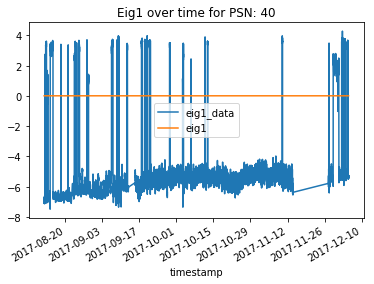

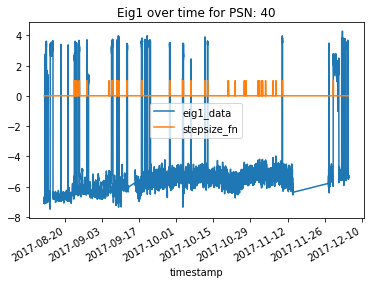

In [18]:
#testing stepsize on all packages
psn=40
temp_df = eig_df[eig_df.psn==psn].reset_index()
#tep_df.reset_index()
jumps_df = find_power_step(temp_df,'eig1', jump=50)
jumps_df['eig1_data']=temp_df.eig1.values
steps = efficient_stepsize(temp_df,ignore_columns=['timestamp','psn']) 
jumps_df['stepsize_fn']= [int(x) for x in steps.eig1.values]
jumps_df.plot(x='timestamp',y=['eig1_data','eig1'])
plt.title('Eig1 over time for PSN: '+str(psn))
plt.show()
jumps_df.plot(x='timestamp',y=['eig1_data','stepsize_fn'])
plt.title('Eig1 over time for PSN: '+str(psn))
plt.show()

/Users/jillianjarrett/anaconda2/envs/py36envir/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


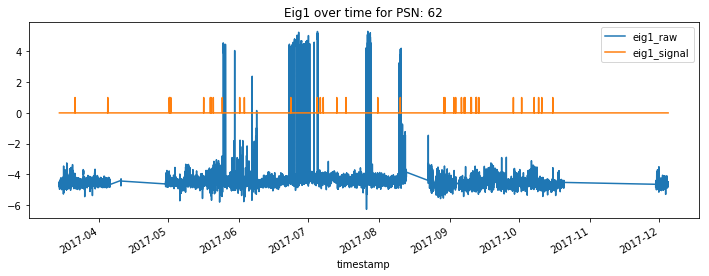

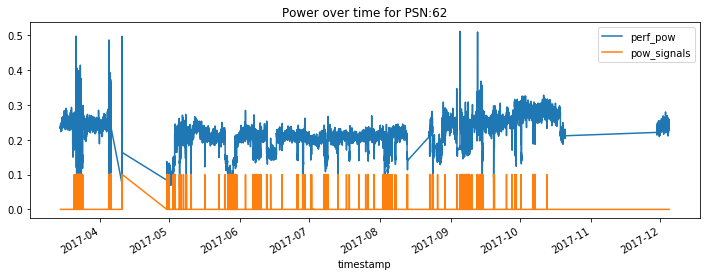

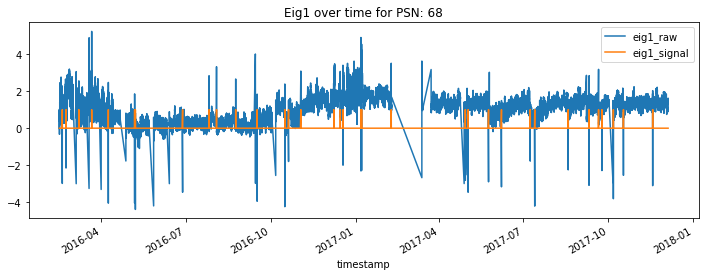

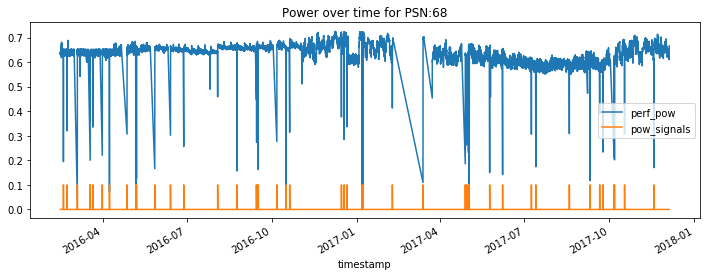

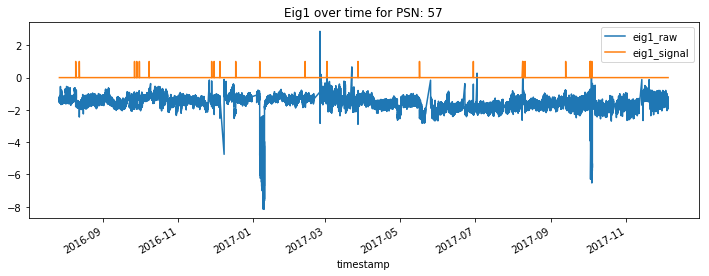

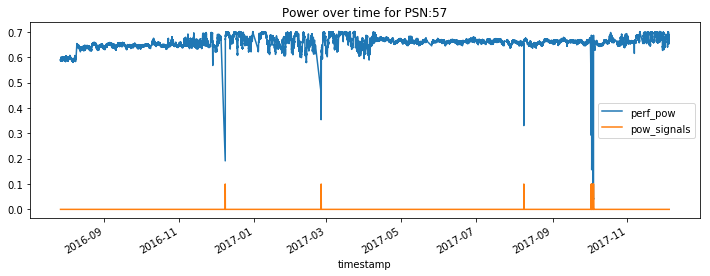

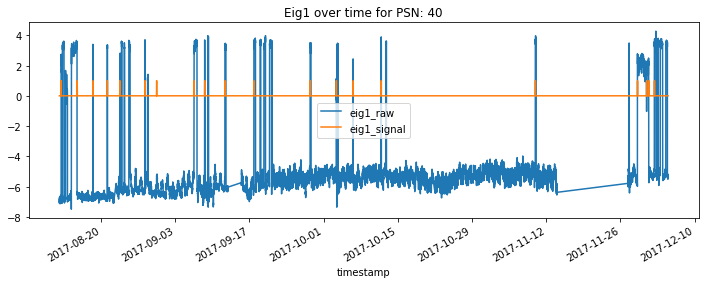

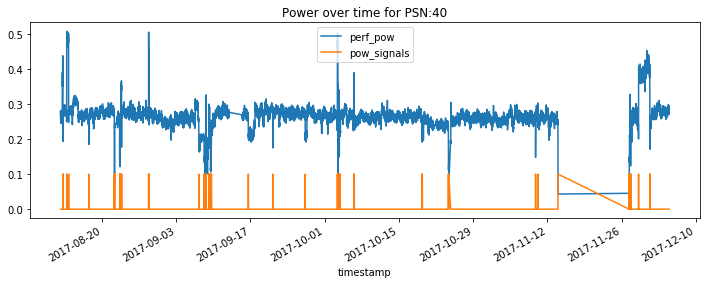

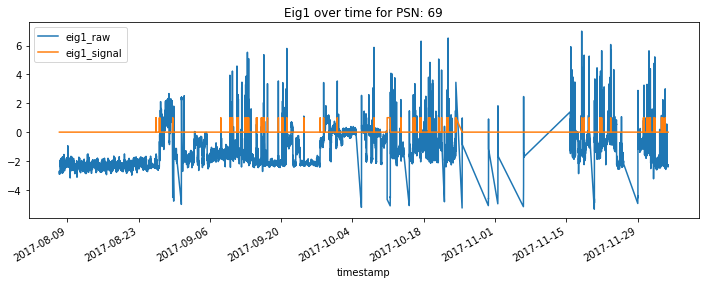

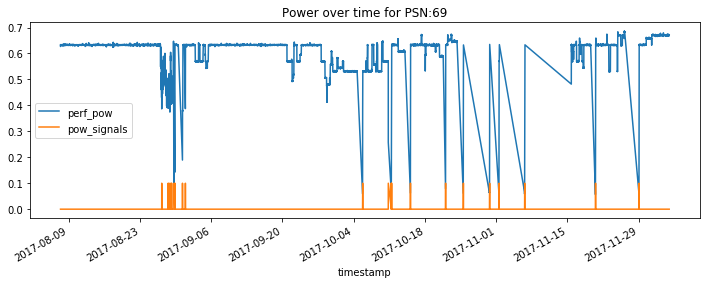

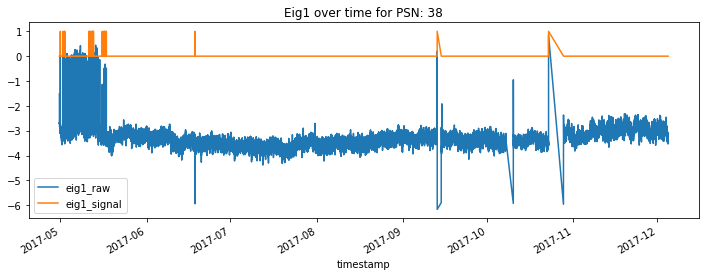

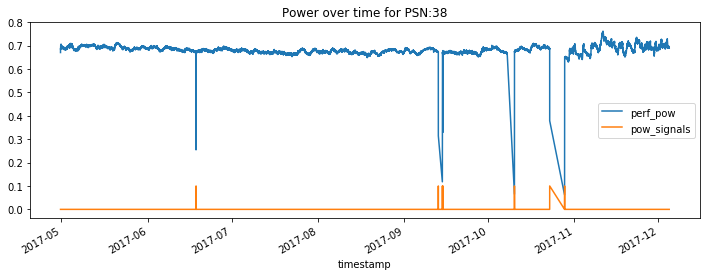

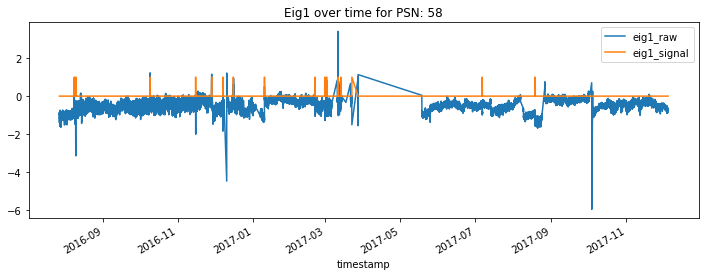

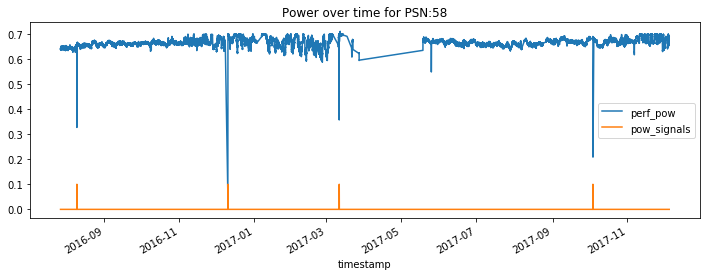

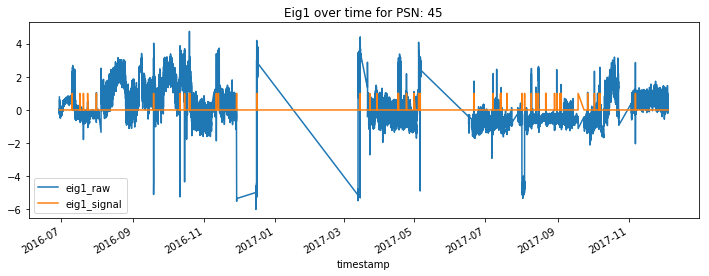

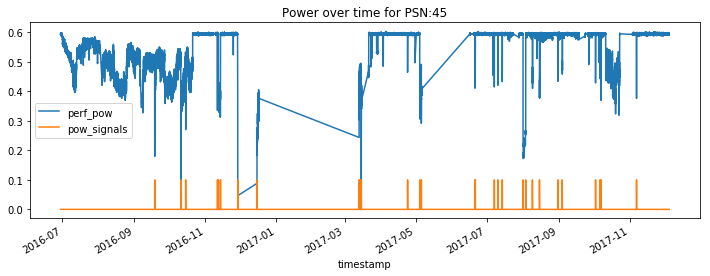

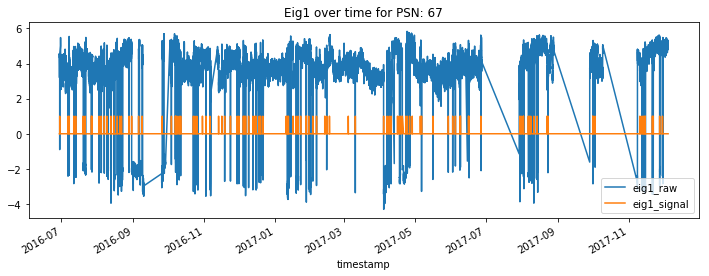

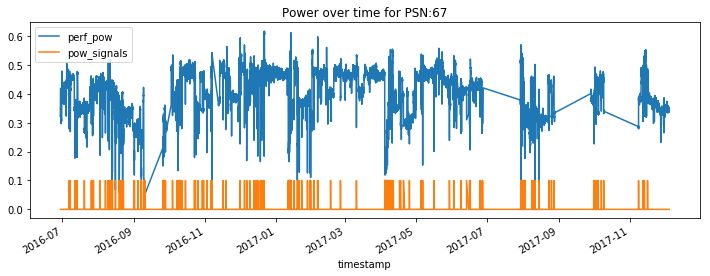

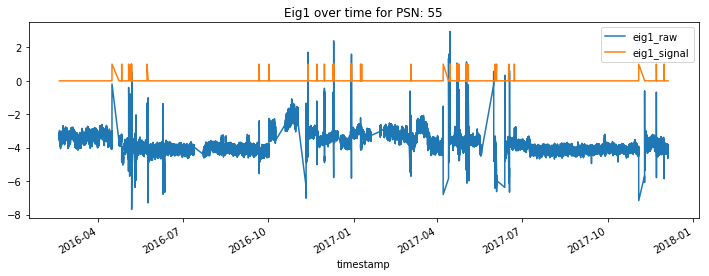

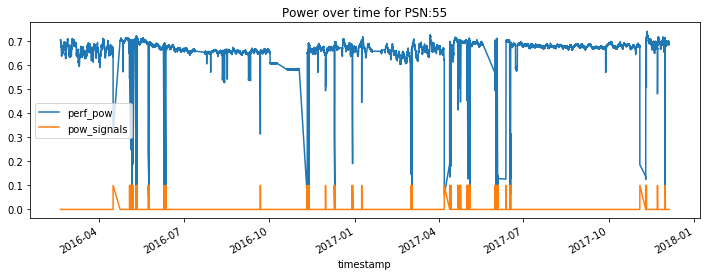

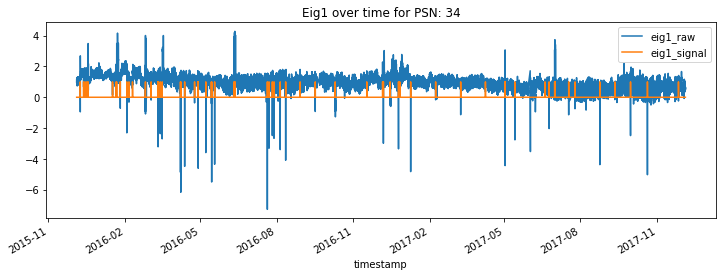

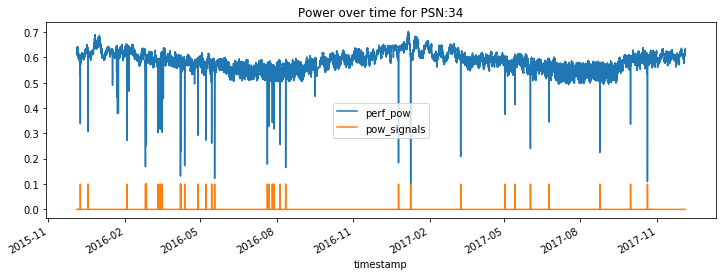

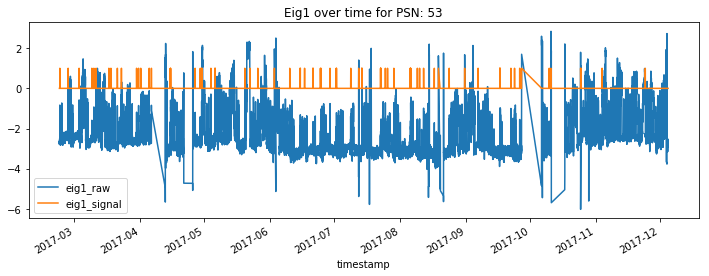

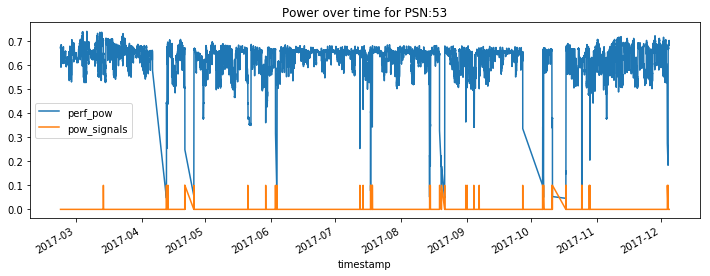

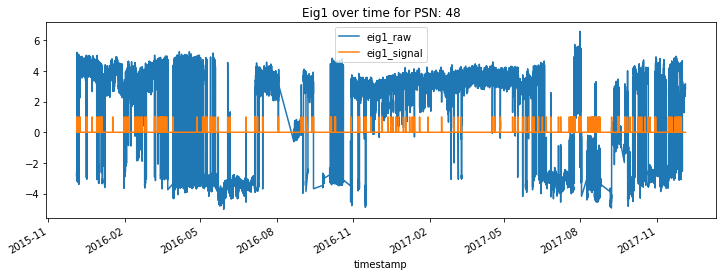

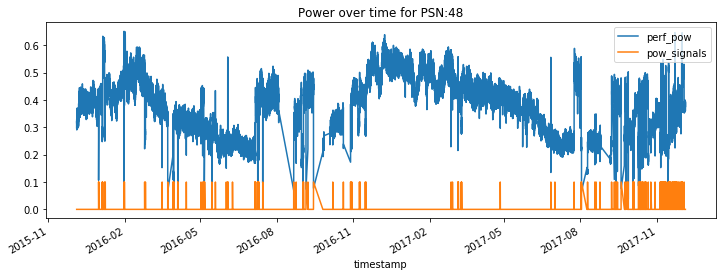

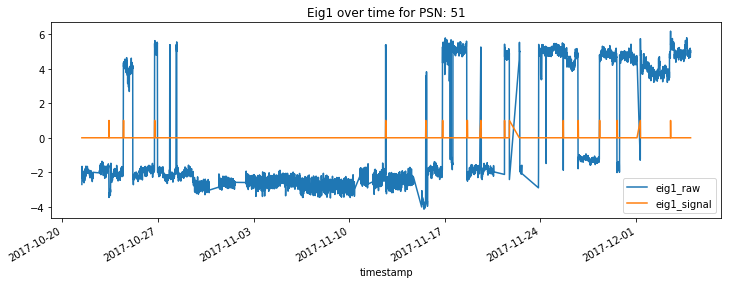

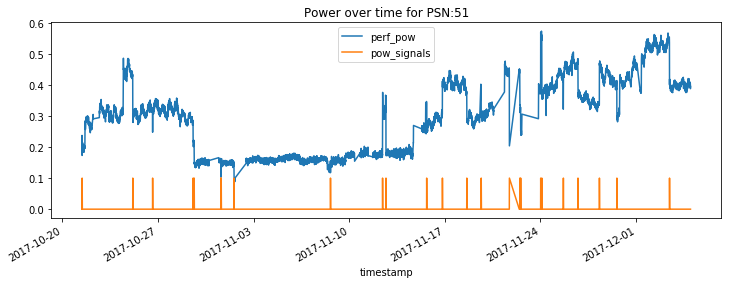

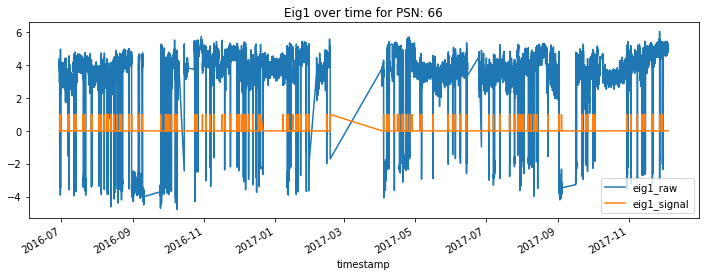

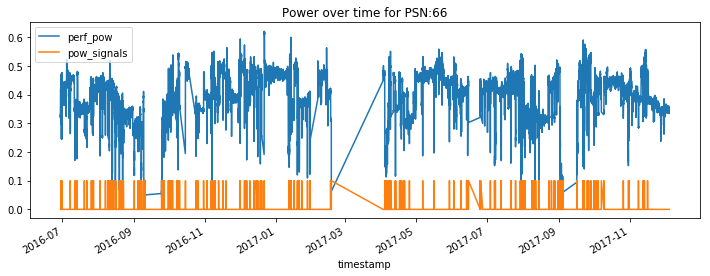

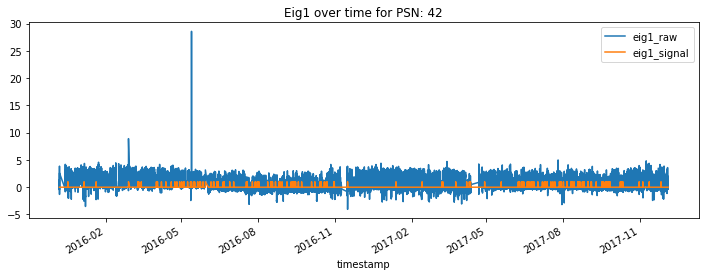

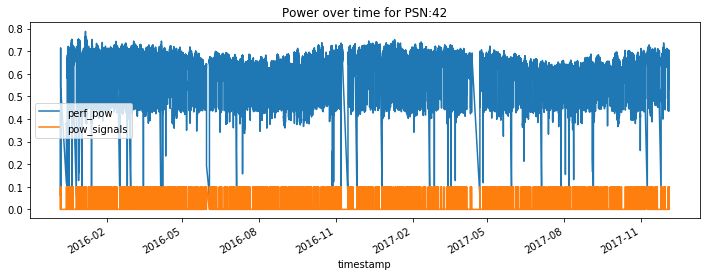

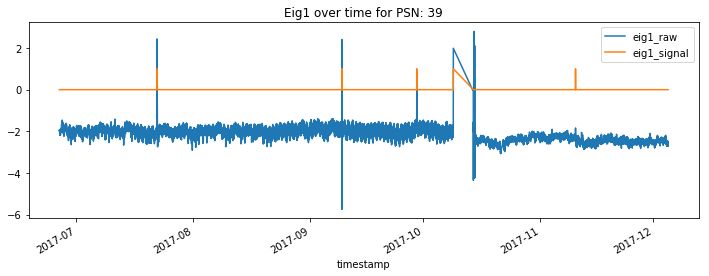

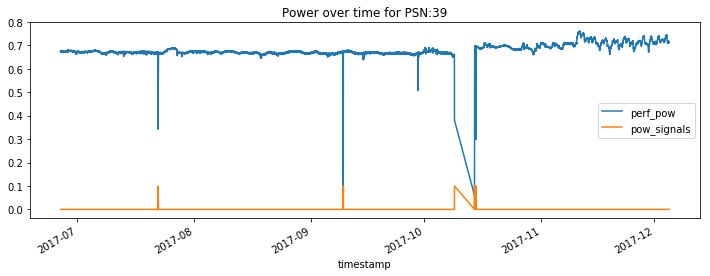

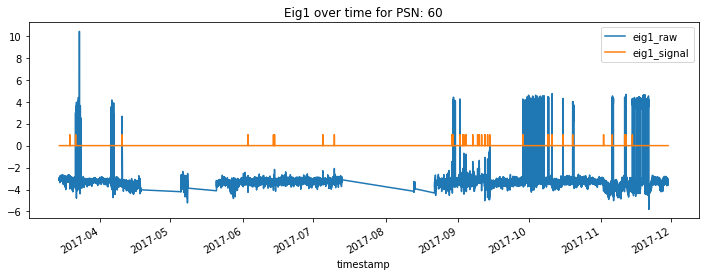

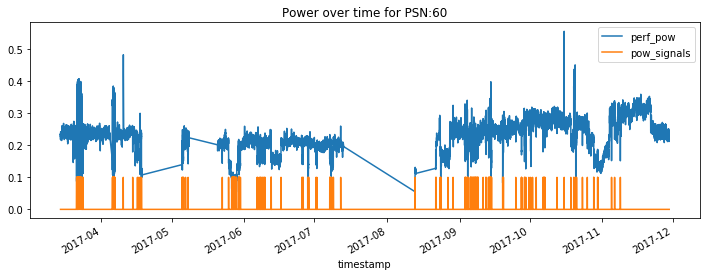

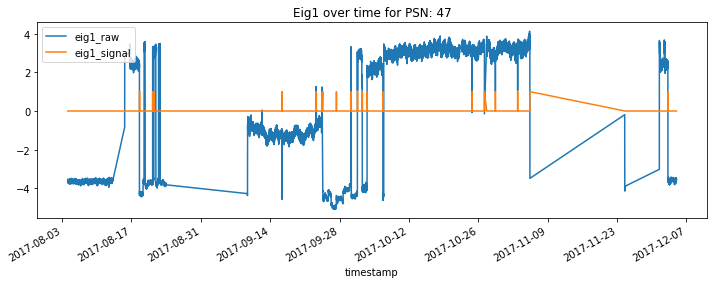

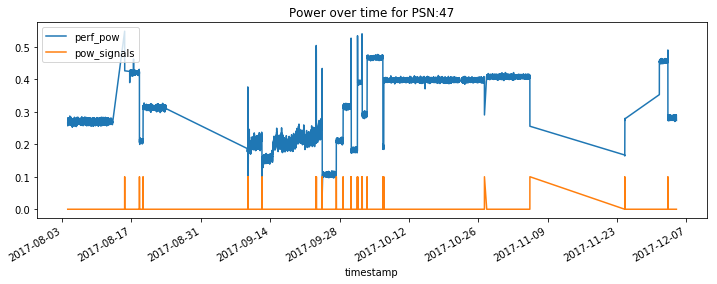

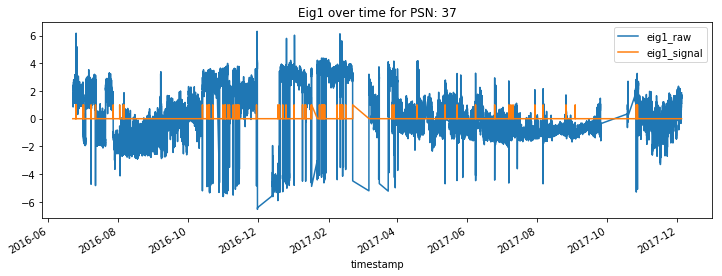

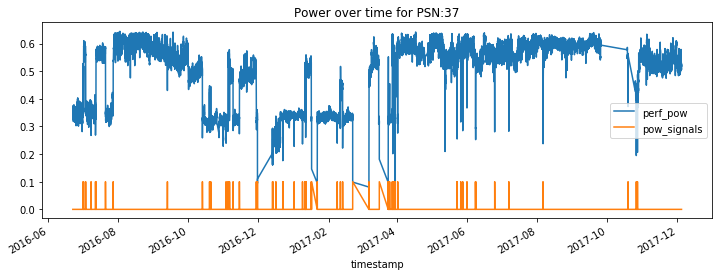

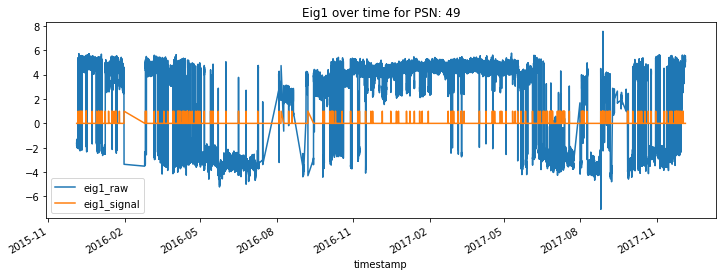

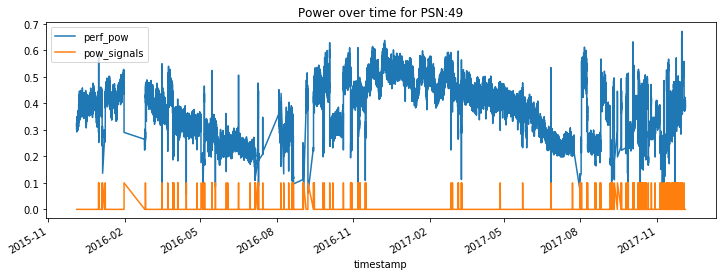

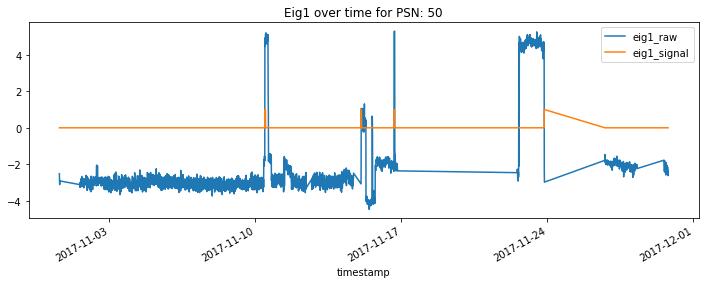

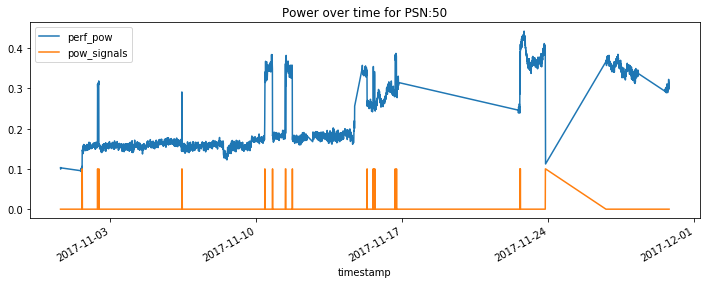

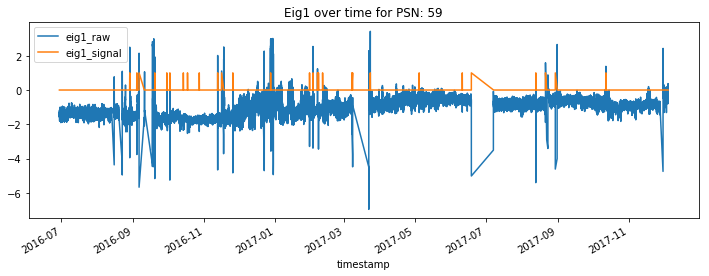

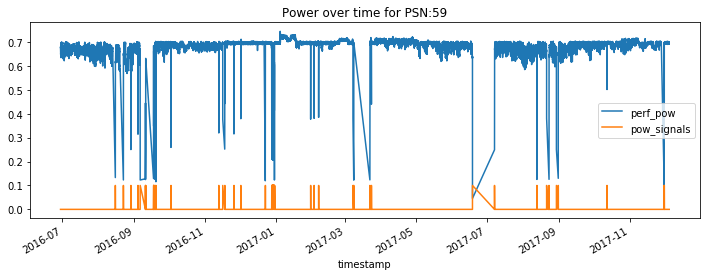

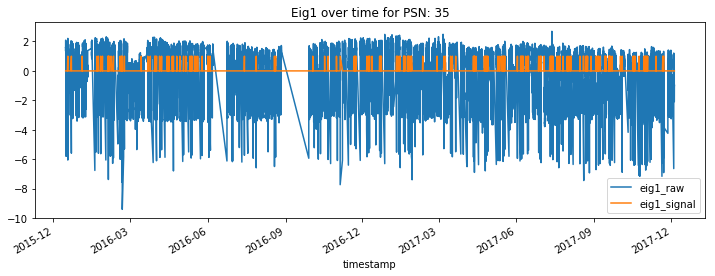

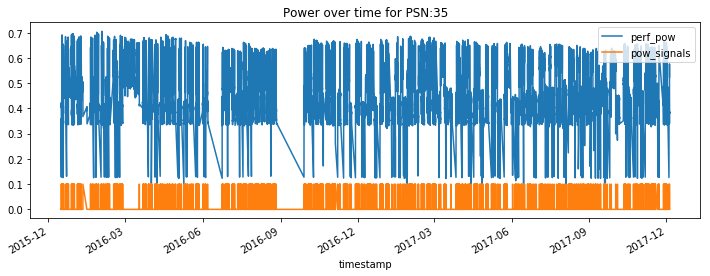

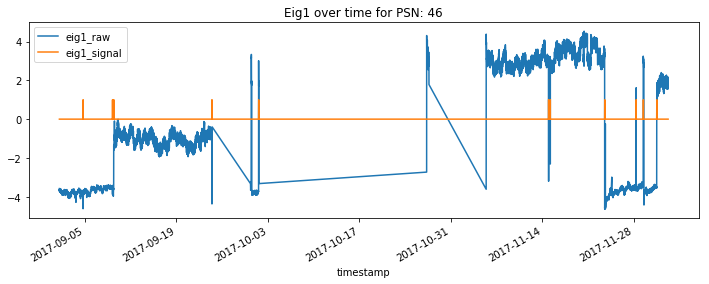

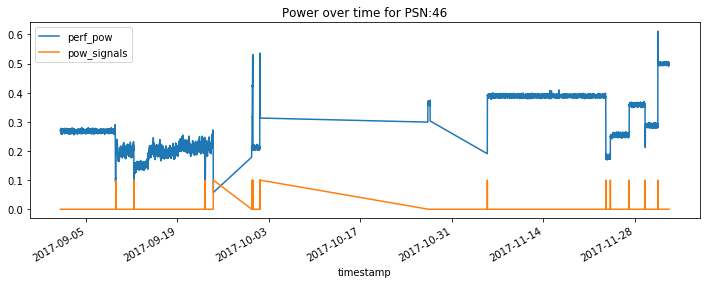

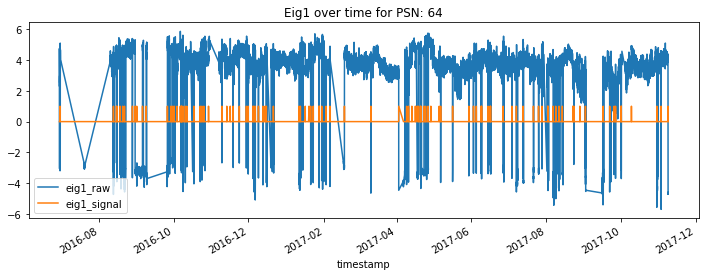

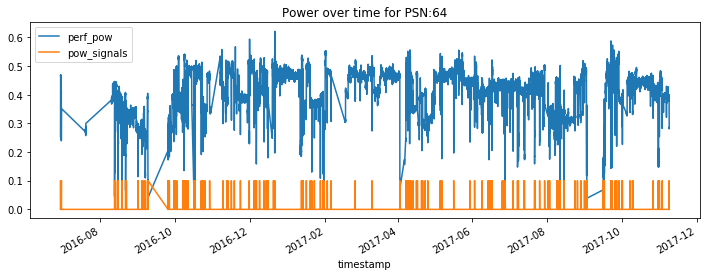

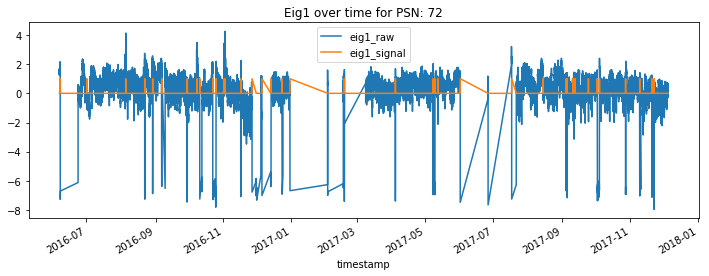

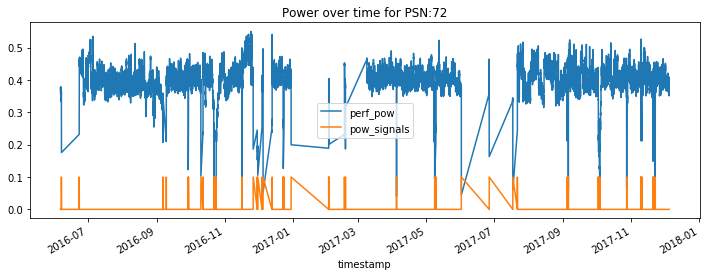

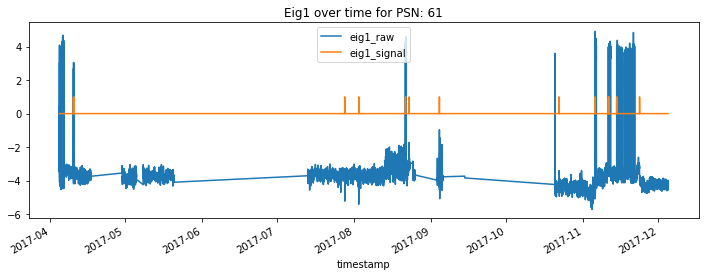

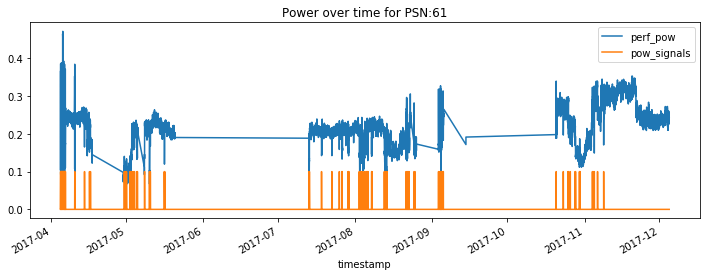

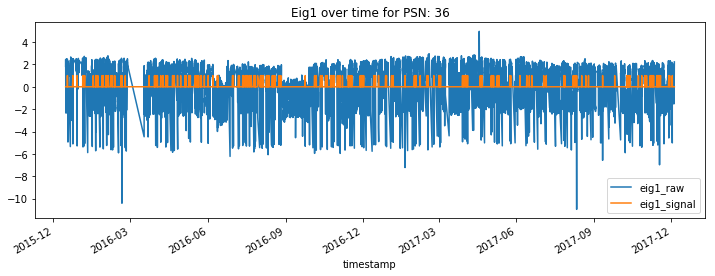

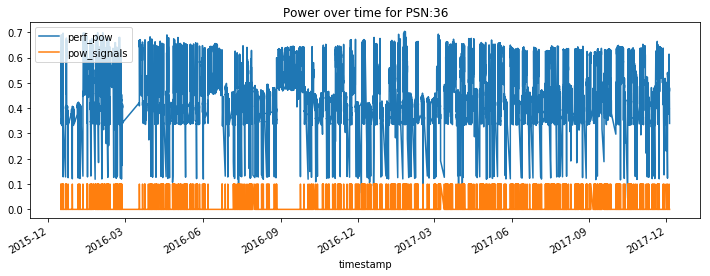

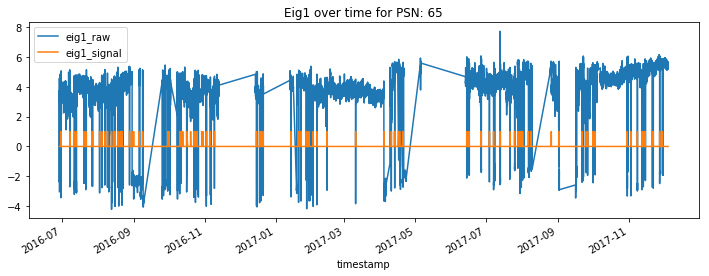

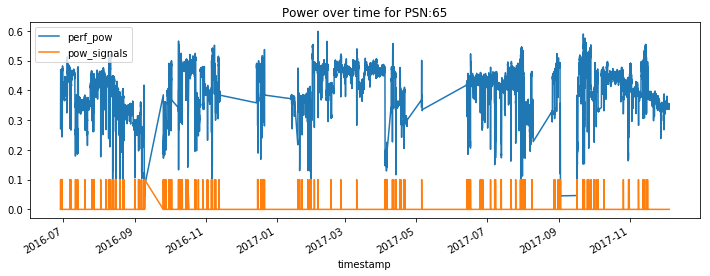

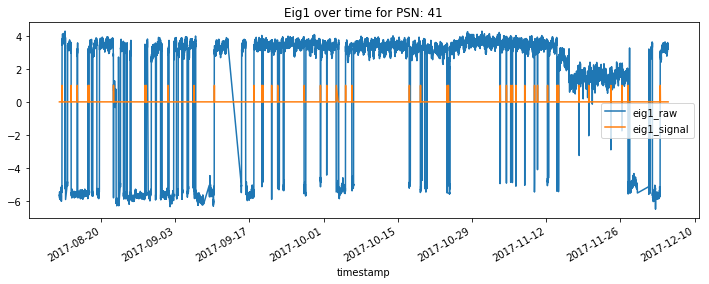

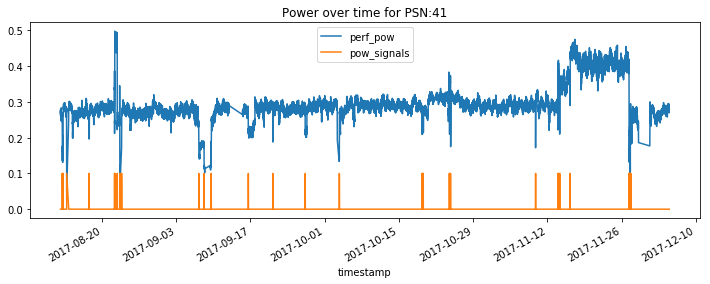

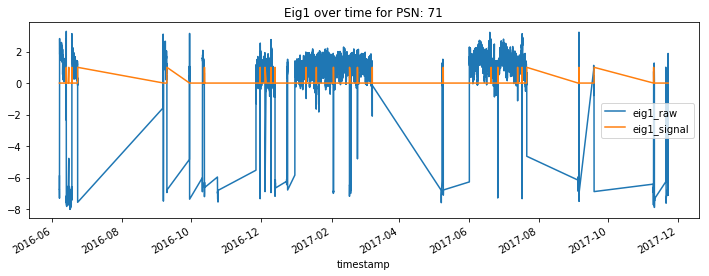

IndexError: index 22778 is out of bounds for axis 0 with size 22778

In [19]:
#testing stepsize on eig1, powerstep on corresponding power column. 
for psn in eig_df.psn.unique():
    plt.rcParams["figure.figsize"] = (12,4)
    temp_df = eig_df[eig_df.psn==psn].reset_index()
    #steps_df = find_power_step(temp_df,'eig1', jump=20)
    steps_df = efficient_stepsize(temp_df,ignore_columns=['timestamp','psn'],threshold=5, rolling_days=1)
    steps_df['eig1']= [int(x) for x in steps_df.eig1.values]
    steps_df['eig1_raw']=temp_df.eig1.values
    steps_df['eig1_signal']=steps_df['eig1']
    steps_df .plot(x='timestamp',y=['eig1_raw','eig1_signal'])
    plt.title('Eig1 over time for PSN: '+str(psn))
    plt.show()

    power_df = data[data.psn==psn].reset_index()
    pow_temp = find_power_step(power_df,'perf_pow', jump=.25)
    power_df['pow_signals'] = pow_temp['perf_pow']/10
    power_df.plot(x='timestamp',y=['perf_pow','pow_signals'])
    plt.title('Power over time for PSN:' +str(psn))
    plt.show()
    
    





### Matching transients found above to shutdown data

In [236]:
def shutdown_labeler(df,eng_st_col= 'sum_eng_st'):
    shutdown_df = pd.DataFrame(columns = df.columns.values)
    shutdown_df['shutdown_flag']=0
    for psn in df['psn'].unique():
        tempdf = df[df['psn']==psn]
        shutdown_flag = np.diff(tempdf[eng_st_col])
        tempdf['shutdown_flag'] = np.array(np.append(shutdown_flag,[0]),dtype=bool) ## cast everything to boolean
        shutdown_df = shutdown_df.append(tempdf)
    return(shutdown_df)

In [237]:
model2_10min_with_shutdowns = shutdown_labeler(model_data[skipped_cols+index_cols])

/Users/jillianjarrett/anaconda2/envs/py36envir/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [238]:
model2_10min_with_shutdowns.head()

sum_esn  sum_eng_st  sum_eng_h      id                  timestamp psn  \
0     48.0       131.0   0.553700  748834 2017-07-03 03:19:59.999998  62   
1     48.0       131.0   0.553700  748835 2017-07-03 03:30:00.000003  62   
2     48.0       131.0   0.553733  748836 2017-07-03 03:39:59.999997  62   
3     48.0       131.0   0.553733  748837 2017-07-03 03:50:00.000002  62   
4     48.0       131.0   0.553733  748838 2017-07-03 03:59:59.999996  62   

   shutdown_flag  
0              0  
1              0  
2              0  
3              0  
4              0

In [239]:
model2_10min_with_shutdowns[model2_10min_with_shutdowns.shutdown_flag !=0]

sum_esn  sum_eng_st  sum_eng_h      id                  timestamp  \
5865        48.0       131.0   0.586300  754699 2017-08-12 21:00:00.000000   
6190        48.0       133.0   0.588300  755024 2017-08-24 15:30:00.000003   
7493        48.0       134.0   0.595567  756330 2017-09-03 15:10:00.000004   
8885        48.0       135.0   0.603400  757722 2017-09-14 09:50:00.000002   
13378       48.0       136.0   0.628333  762215 2017-10-15 16:30:00.000000   
13964       48.0       137.0   0.631600  762801 2017-10-19 18:19:59.999998   
13989       48.0       138.0   0.631733  762826 2017-10-20 13:30:00.000000   
14770       48.0       139.0   0.636067  763607 2017-12-04 23:49:59.999995   
1593087     48.0       127.0   0.502233  739595 2017-04-05 15:10:00.000004   
1593105     48.0       129.0   0.502367  739613 2017-04-10 12:50:00.000002   
1594306     48.0       130.0   0.509133  740814 2017-05-08 08:49:59.999995   
15212       16.0        42.0   0.014167  764049 2016-02-18 12:39:59.999997   
15792       16.0        43.0   0.017400  764629 2016-02-22 15:10:00.000004   
16885       16.0        44.0   0.023467  765722 2016-03-01 05:49:59.999995   
18579       16.0        45.0   0.032900  767416 2016-03-16 11:00:00.000003   
20134       16.0        46.0   0.041533  768971 2016-03-29 08:29:59.999996   
21238       16.0        48.0   0.047700  770075 2016-04-08 07:30:00.000000   
23102       16.0        49.0   0.058100  771939 2016-04-21 08:29:59.999996   
24451       16.0        50.0   0.065600  773290 2016-05-06 18:10:00.000004   
24563       16.0        51.0   0.066233  773402 2016-05-07 15:00:00.000000   
26710       16.0        53.0   0.078167  775550 2016-05-22 13:49:59.999998   
28775       16.0        54.0   0.089667  777615 2016-06-10 18:10:00.000004   
30770       16.0        56.0   0.100767  779611 2016-06-27 06:39:59.999997   
36026       16.0        57.0   0.130033  784867 2016-08-03 06:59:59.999996   
39010       16.0        58.0   0.146600  787851 2016-08-24 04:10:00.000001   
41905       16.0        59.0   0.162700  790746 2016-09-13 07:10:00.000001   
41923       16.0        60.0   0.162800  790764 2016-09-14 13:49:59.999998   
42168       16.0        61.0   0.164167  791009 2016-09-16 07:49:59.999998   
44487       16.0        62.0   0.177067  793328 2016-10-02 12:00:00.000000   
46423       16.0        67.0   0.187867  795264 2016-10-19 23:09:59.999997   
...          ...         ...        ...     ...                        ...   
1518750      4.0        51.0   0.411133  665254 2016-05-17 20:09:59.999997   
1519472      4.0        52.0   0.415200  665976 2016-05-23 15:50:00.000002   
1521855      4.0        55.0   0.428500  668359 2016-06-10 04:19:59.999995   
1536529      4.0        56.0   0.510100  683033 2016-09-20 21:00:00.000000   
1541167      4.0        57.0   0.538333  687671 2016-10-26 13:19:59.999995   
1542430      4.0        58.0   0.545633  688934 2016-11-05 05:09:59.999997   
1546068      4.0        59.0   0.568000  692572 2016-12-10 10:40:00.000004   
1548442      4.0        60.0   0.582133  694946 2016-12-28 09:59:59.999996   
1551354      4.0        61.0   0.615467  697858 2017-02-08 06:10:00.000004   
1556539      4.0        62.0   0.644300  703043 2017-03-16 16:40:00.000004   
1556849      4.0        63.0   0.646300  703353 2017-03-19 11:00:00.000003   
1557326      4.0        64.0   0.648933  703830 2017-03-22 20:40:00.000001   
1557341      4.0        65.0   0.649033  703845 2017-03-23 00:00:00.000000   
1557407      4.0        66.0   0.649400  703911 2017-03-23 12:39:59.999997   
1559372      4.0        67.0   0.661233  705876 2017-04-07 13:19:59.999995   
1560765      4.0        72.0   0.669000  707269 2017-05-01 09:59:59.999996   
1560968      4.0        73.0   0.670133  707472 2017-05-03 05:09:59.999997   
1564816      4.0        74.0   0.691900  711320 2017-05-31 09:50:00.000002   
1564819      4.0        76.0   0.692033  711323 2017-06-03 17:29:59.999996   
1564821      4.0        77.0   

In [240]:
model2_10min_with_shutdowns[model2_10min_with_shutdowns.shutdown_flag !=0].psn.value_counts()

36    289
35    232
34     87
42     49
45     46
68     45
49     41
48     38
56     37
55     32
59     30
57     27
64     23
71     23
72     22
58     21
65     21
37     21
67     19
66     19
53     19
69     15
51     13
60     12
62     11
61     11
41      8
47      7
46      6
40      5
50      5
38      4
39      2
Name: psn, dtype: int64

In [241]:
psn_poc = 46
poc_df = model2_10min_with_shutdowns[model2_10min_with_shutdowns.psn==psn_poc]

In [242]:
poc_df[(poc_df.sum_eng_st== 160)|(poc_df.sum_eng_st== 161)]

Empty DataFrame
Columns: [sum_esn, sum_eng_st, sum_eng_h, id, timestamp, psn, shutdown_flag]
Index: []

In [243]:
#poc_df.loc[[333980,333981,333982,333983]]

In [244]:
poc_df = poc_df.set_index(['psn','timestamp'])
poc_df.head()

sum_esn  sum_eng_st  sum_eng_h      id  \
psn timestamp                                                            
46  2017-09-01 02:40:00.000001     39.0       199.0   0.474433  355840   
    2017-09-01 02:49:59.999995     39.0       199.0   0.474433  355841   
    2017-09-01 03:00:00.000000     39.0       199.0   0.474433  355842   
    2017-09-01 03:10:00.000004     39.0       199.0   0.474433  355843   
    2017-09-01 03:19:59.999998     39.0       199.0   0.474433  355844   

                                shutdown_flag  
psn timestamp                                  
46  2017-09-01 02:40:00.000001              0  
    2017-09-01 02:49:59.999995              0  
    2017-09-01 03:00:00.000000              0  
    2017-09-01 03:10:00.000004              0  
    2017-09-01 03:19:59.999998              0

In [245]:
poc_df = poc_df[['shutdown_flag']]
poc_df.head()

shutdown_flag
psn timestamp                                
46  2017-09-01 02:40:00.000001              0
    2017-09-01 02:49:59.999995              0
    2017-09-01 03:00:00.000000              0
    2017-09-01 03:10:00.000004              0
    2017-09-01 03:19:59.999998              0

In [246]:
eig_df = reduced_df[['psn','timestamp',0,1,2,3,4,5,6,7,8,9,10]]
eig_df.columns = ['psn','timestamp','eig0','eig1','eig2','eig3','eig4','eig5','eig6','eig7','eig8','eig9','eig10']
eig_poc_df = eig_df[eig_df.psn==psn_poc]
eig_poc_df.head()

psn                  timestamp      eig0      eig1      eig2  \
1211454   46 2017-09-01 02:40:00.000001  8.538402 -3.578300 -0.215337   
1211455   46 2017-09-01 02:49:59.999995  8.790378 -3.716896 -0.487711   
1211456   46 2017-09-01 03:00:00.000000  8.607317 -3.643288 -0.437759   
1211457   46 2017-09-01 03:10:00.000004  8.737745 -3.600427 -0.355955   
1211458   46 2017-09-01 03:19:59.999998  8.847038 -3.715035 -0.554343   

             eig3      eig4      eig5      eig6      eig7      eig8      eig9  \
1211454 -1.408313 -1.143952  0.867320  2.320707  1.885600 -0.987784 -0.590394   
1211455 -1.443672 -0.954555  0.737441  1.835612  1.863936 -0.952506 -0.537380   
1211456 -1.399963 -0.992244  0.616588  1.864547  1.809160 -0.967209 -0.500187   
1211457 -1.405162 -0.925563  0.948998  2.374776  1.848993 -0.784925 -0.463892   
1211458 -1.580313 -1.143577  0.594194  1.627616  1.881736 -1.020163 -0.655379   

            eig10  
1211454 -0.007877  
1211455 -0.049653  
1211456  0.053814  
1211457 -0.126135  
1211458  0.068429

/Users/jillianjarrett/anaconda2/envs/py36envir/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


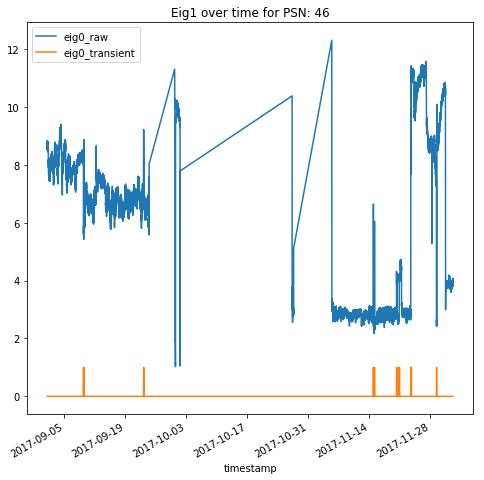

In [247]:
temp_df = eig_poc_df[['timestamp','psn','eig0']].reset_index()
    #steps_df = find_power_step(temp_df,'eig1', jump=20)
steps_df = efficient_stepsize(temp_df,ignore_columns=['timestamp','psn'],threshold=5, rolling_days=5)
steps_df['eig0']= [int(x) for x in steps_df.eig0.values]
steps_df['eig0_raw']=temp_df.eig0.values
steps_df['eig0_transient']=steps_df['eig0']
steps_df.plot(x='timestamp',y=['eig0_raw','eig0_transient'])
plt.title('Eig1 over time for PSN: '+str(psn_poc))
plt.show()


In [220]:
steps_df = steps_df.set_index(['psn','timestamp'])
steps_df = steps_df[['eig0_transient']]
steps_df.head()

eig0_transient
psn timestamp                                 
46  2017-09-01 02:40:00.000001               0
    2017-09-01 02:49:59.999995               0
    2017-09-01 03:00:00.000000               0
    2017-09-01 03:10:00.000004               0
    2017-09-01 03:19:59.999998               0

In [248]:
#uses jareds stepsize function
temp_df = eig_poc_df[['timestamp','psn','eig0']].reset_index()
temp_df.set_index(['psn', 'timestamp'], inplace=True)
del temp_df['index']
print(temp_df.head())
eig_ss_class = StepSize(threshold=5,rolling_days=7)

transformed_eig_ss = eig_ss_class.fit_transform(temp_df);

transformed_eig_ss.eig0 = [int(x) for x in transformed_eig_ss.eig0.values]
transformed_eig_ss.head()


                                    eig0
psn timestamp                           
46  2017-09-01 02:40:00.000001  8.538402
    2017-09-01 02:49:59.999995  8.790378
    2017-09-01 03:00:00.000000  8.607317
    2017-09-01 03:10:00.000004  8.737745
    2017-09-01 03:19:59.999998  8.847038


eig0
psn timestamp                       
46  2017-09-01 02:40:00.000001     0
    2017-09-01 02:49:59.999995     0
    2017-09-01 03:00:00.000000     0
    2017-09-01 03:10:00.000004     0
    2017-09-01 03:19:59.999998     0

In [249]:
#uses jareds refactored code for power jumps
power_df = data[data.psn==psn_poc]
power_df.set_index(['psn', 'timestamp'], inplace=True)
power_df= power_df[['perf_pow']]
power_class = PowerStepSize(power_col='perf_pow')
transformed_pow = power_class.fit_transform(power_df);
#print(transformed)
# power_df['pow_transients'] = int(transformed)
# power_df.head()
transformed_pow.perf_pow = [int(x) for x in transformed_pow.perf_pow.values]
transformed_pow.head()


psn  timestamp                 
46   2017-09-01 02:40:00.000001    False
     2017-09-01 02:49:59.999995    False
     2017-09-01 03:00:00.000000    False
     2017-09-01 03:10:00.000004    False
     2017-09-01 03:19:59.999998    False
     2017-09-01 03:30:00.000003    False
     2017-09-01 03:39:59.999997    False
     2017-09-01 03:50:00.000002    False
     2017-09-01 03:59:59.999996    False
     2017-09-01 04:10:00.000001    False
     2017-09-01 04:19:59.999995    False
     2017-09-01 04:30:00.000000    False
     2017-09-01 04:40:00.000004    False
     2017-09-01 04:49:59.999998    False
     2017-09-01 05:00:00.000003    False
     2017-09-01 05:09:59.999997    False
     2017-09-01 05:20:00.000002    False
     2017-09-01 05:29:59.999996    False
     2017-09-01 05:40:00.000001    False
     2017-09-01 05:49:59.999995    False
     2017-09-01 06:00:00.000000    False
     2017-09-01 06:10:00.000004    False
     2017-09-01 06:19:59.999998    False
     2017-09-01 06:30:00.

perf_pow
psn timestamp                           
46  2017-09-01 02:40:00.000001         0
    2017-09-01 02:49:59.999995         0
    2017-09-01 03:00:00.000000         0
    2017-09-01 03:10:00.000004         0
    2017-09-01 03:19:59.999998         0

/Users/jillianjarrett/anaconda2/envs/py36envir/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


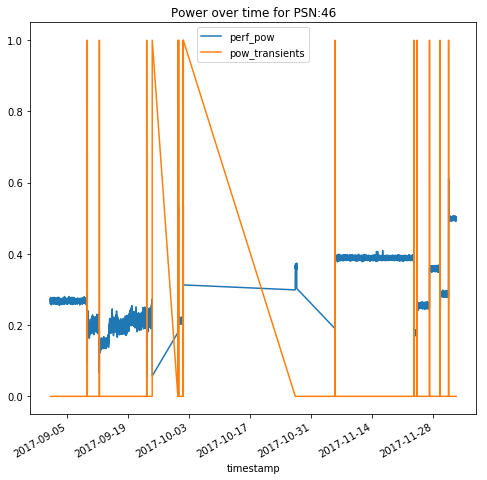

In [250]:
power_df = data[data.psn==psn_poc].reset_index()
pow_temp = find_power_step(power_df,'perf_pow', jump=.25)
power_df['pow_transients'] = pow_temp['perf_pow']
power_df.plot(x='timestamp',y=['perf_pow','pow_transients'])
plt.title('Power over time for PSN:' +str(psn_poc))
plt.show()
    

In [251]:
power_df.set_index(['psn','timestamp'],inplace=True)
power_df = power_df[['pow_transients']]
power_df.head(20)

pow_transients
psn timestamp                                 
46  2017-09-01 02:40:00.000001             0.0
    2017-09-01 02:49:59.999995             0.0
    2017-09-01 03:00:00.000000             0.0
    2017-09-01 03:10:00.000004             0.0
    2017-09-01 03:19:59.999998             0.0
    2017-09-01 03:30:00.000003             0.0
    2017-09-01 03:39:59.999997             0.0
    2017-09-01 03:50:00.000002             0.0
    2017-09-01 03:59:59.999996             0.0
    2017-09-01 04:10:00.000001             0.0
    2017-09-01 04:19:59.999995             0.0
    2017-09-01 04:30:00.000000             0.0
    2017-09-01 04:40:00.000004             0.0
    2017-09-01 04:49:59.999998             0.0
    2017-09-01 05:00:00.000003             0.0
    2017-09-01 05:09:59.999997             0.0
    2017-09-01 05:20:00.000002             0.0
    2017-09-01 05:29:59.999996             0.0
    2017-09-01 05:40:00.000001             0.0
    2017-09-01 05:49:59.999995             0.0

In [252]:
eig_poc_df= eig_poc_df.set_index(['psn','timestamp'])
eig_poc_df.head()

eig0      eig1      eig2      eig3  \
psn timestamp                                                            
46  2017-09-01 02:40:00.000001  8.538402 -3.578300 -0.215337 -1.408313   
    2017-09-01 02:49:59.999995  8.790378 -3.716896 -0.487711 -1.443672   
    2017-09-01 03:00:00.000000  8.607317 -3.643288 -0.437759 -1.399963   
    2017-09-01 03:10:00.000004  8.737745 -3.600427 -0.355955 -1.405162   
    2017-09-01 03:19:59.999998  8.847038 -3.715035 -0.554343 -1.580313   

                                    eig4      eig5      eig6      eig7  \
psn timestamp                                                            
46  2017-09-01 02:40:00.000001 -1.143952  0.867320  2.320707  1.885600   
    2017-09-01 02:49:59.999995 -0.954555  0.737441  1.835612  1.863936   
    2017-09-01 03:00:00.000000 -0.992244  0.616588  1.864547  1.809160   
    2017-09-01 03:10:00.000004 -0.925563  0.948998  2.374776  1.848993   
    2017-09-01 03:19:59.999998 -1.143577  0.594194  1.627616  1.881736   

                                    eig8      eig9     eig10  
psn timestamp                                                 
46  2017-09-01 02:40:00.000001 -0.987784 -0.590394 -0.007877  
    2017-09-01 02:49:59.999995 -0.952506 -0.537380 -0.049653  
    2017-09-01 03:00:00.000000 -0.967209 -0.500187  0.053814  
    2017-09-01 03:10:00.000004 -0.784925 -0.463892 -0.126135  
    2017-09-01 03:19:59.999998 -1.020163 -0.655379  0.068429

In [253]:
#old functions
#eig_poc_df = eig_poc_df.merge(steps_df,how='left',left_index=True, right_index=True)
#eig_poc_df = eig_poc_df.merge(power_df,how='left',left_index=True, right_index=True)


In [254]:
poc_df.head()

shutdown_flag
psn timestamp                                
46  2017-09-01 02:40:00.000001              0
    2017-09-01 02:49:59.999995              0
    2017-09-01 03:00:00.000000              0
    2017-09-01 03:10:00.000004              0
    2017-09-01 03:19:59.999998              0

In [255]:
eig_poc_df = eig_poc_df.merge(transformed_eig_ss,how='left',left_index=True, right_index=True)
eig_poc_df = eig_poc_df.merge(transformed_pow,how='left',left_index=True, right_index=True)

eig_poc_df = eig_poc_df.merge(poc_df,how='left',left_index=True, right_index=True)

eig_poc_df.head()

eig0_x      eig1      eig2      eig3  \
psn timestamp                                                            
46  2017-09-01 02:40:00.000001  8.538402 -3.578300 -0.215337 -1.408313   
    2017-09-01 02:49:59.999995  8.790378 -3.716896 -0.487711 -1.443672   
    2017-09-01 03:00:00.000000  8.607317 -3.643288 -0.437759 -1.399963   
    2017-09-01 03:10:00.000004  8.737745 -3.600427 -0.355955 -1.405162   
    2017-09-01 03:19:59.999998  8.847038 -3.715035 -0.554343 -1.580313   

                                    eig4      eig5      eig6      eig7  \
psn timestamp                                                            
46  2017-09-01 02:40:00.000001 -1.143952  0.867320  2.320707  1.885600   
    2017-09-01 02:49:59.999995 -0.954555  0.737441  1.835612  1.863936   
    2017-09-01 03:00:00.000000 -0.992244  0.616588  1.864547  1.809160   
    2017-09-01 03:10:00.000004 -0.925563  0.948998  2.374776  1.848993   
    2017-09-01 03:19:59.999998 -1.143577  0.594194  1.627616  1.881736   

                                    eig8      eig9     eig10  eig0_y  \
psn timestamp                                                          
46  2017-09-01 02:40:00.000001 -0.987784 -0.590394 -0.007877       0   
    2017-09-01 02:49:59.999995 -0.952506 -0.537380 -0.049653       0   
    2017-09-01 03:00:00.000000 -0.967209 -0.500187  0.053814       0   
    2017-09-01 03:10:00.000004 -0.784925 -0.463892 -0.126135       0   
    2017-09-01 03:19:59.999998 -1.020163 -0.655379  0.068429       0   

                                perf_pow  shutdown_flag  
psn timestamp                                            
46  2017-09-01 02:40:00.000001         0              0  
    2017-09-01 02:49:59.999995         0              0  
    2017-09-01 03:00:00.000000         0              0  
    2017-09-01 03:10:00.000004         0              0  
    2017-09-01 03:19:59.999998         0              0

In [256]:
eig_poc_df.columns = ['eig0', 'eig1', 'eig2', 'eig3', 'eig4', 'eig5', 'eig6', 'eig7', 'eig8',
       'eig9', 'eig10', 'eig0_transient', 'pow_transients', 'shutdown_flag']
eig_poc_df.head()

eig0      eig1      eig2      eig3  \
psn timestamp                                                            
46  2017-09-01 02:40:00.000001  8.538402 -3.578300 -0.215337 -1.408313   
    2017-09-01 02:49:59.999995  8.790378 -3.716896 -0.487711 -1.443672   
    2017-09-01 03:00:00.000000  8.607317 -3.643288 -0.437759 -1.399963   
    2017-09-01 03:10:00.000004  8.737745 -3.600427 -0.355955 -1.405162   
    2017-09-01 03:19:59.999998  8.847038 -3.715035 -0.554343 -1.580313   

                                    eig4      eig5      eig6      eig7  \
psn timestamp                                                            
46  2017-09-01 02:40:00.000001 -1.143952  0.867320  2.320707  1.885600   
    2017-09-01 02:49:59.999995 -0.954555  0.737441  1.835612  1.863936   
    2017-09-01 03:00:00.000000 -0.992244  0.616588  1.864547  1.809160   
    2017-09-01 03:10:00.000004 -0.925563  0.948998  2.374776  1.848993   
    2017-09-01 03:19:59.999998 -1.143577  0.594194  1.627616  1.881736   

                                    eig8      eig9     eig10  eig0_transient  \
psn timestamp                                                                  
46  2017-09-01 02:40:00.000001 -0.987784 -0.590394 -0.007877               0   
    2017-09-01 02:49:59.999995 -0.952506 -0.537380 -0.049653               0   
    2017-09-01 03:00:00.000000 -0.967209 -0.500187  0.053814               0   
    2017-09-01 03:10:00.000004 -0.784925 -0.463892 -0.126135               0   
    2017-09-01 03:19:59.999998 -1.020163 -0.655379  0.068429               0   

                                pow_transients  shutdown_flag  
psn timestamp                                                  
46  2017-09-01 02:40:00.000001               0              0  
    2017-09-01 02:49:59.999995               0              0  
    2017-09-01 03:00:00.000000               0              0  
    2017-09-01 03:10:00.000004               0              0  
    2017-09-01 03:19:59.999998               0              0

In [257]:
eig_poc_df.corr()

eig0      eig1      eig2      eig3      eig4      eig5  \
eig0            1.000000 -0.950600 -0.059315 -0.628862 -0.646693  0.263210   
eig1           -0.950600  1.000000  0.034418  0.732251  0.663288 -0.241045   
eig2           -0.059315  0.034418  1.000000 -0.510841  0.694559 -0.957235   
eig3           -0.628862  0.732251 -0.510841  1.000000  0.176983  0.371668   
eig4           -0.646693  0.663288  0.694559  0.176983  1.000000 -0.801777   
eig5            0.263210 -0.241045 -0.957235  0.371668 -0.801777  1.000000   
eig6           -0.016159  0.042085  0.918619 -0.418890  0.664046 -0.909293   
eig7            0.832086 -0.859624 -0.336440 -0.510986 -0.872034  0.504570   
eig8           -0.180804  0.202496  0.152939 -0.030998  0.228443 -0.332014   
eig9            0.214444 -0.259245  0.028434 -0.323626 -0.189005 -0.131991   
eig10           0.128510 -0.097918  0.501489 -0.222052  0.262528 -0.303900   
eig0_transient  0.096149 -0.055373  0.031489 -0.020026 -0.022195 -0.005095   
pow_transients  0.037601 -0.018174 -0.007892 -0.013576 -0.018771  0.015915   
shutdown_flag   0.015037 -0.008384 -0.011694 -0.002466 -0.016961  0.023270   

                    eig6      eig7      eig8      eig9     eig10  \
eig0           -0.016159  0.832086 -0.180804  0.214444  0.128510   
eig1            0.042085 -0.859624  0.202496 -0.259245 -0.097918   
eig2            0.918619 -0.336440  0.152939  0.028434  0.501489   
eig3           -0.418890 -0.510986 -0.030998 -0.323626 -0.222052   
eig4            0.664046 -0.872034  0.228443 -0.189005  0.262528   
eig5           -0.909293  0.504570 -0.332014 -0.131991 -0.303900   
eig6            1.000000 -0.277534  0.231274  0.143897  0.321441   
eig7           -0.277534  1.000000 -0.271288  0.184257 -0.009040   
eig8            0.231274 -0.271288  1.000000  0.784141 -0.548491   
eig9            0.143897  0.184257  0.784141  1.000000 -0.672672   
eig10           0.321441 -0.009040 -0.548491 -0.672672  1.000000   
eig0_transient  0.035627  0.025274 -0.103121 -0.036216  0.068104   
pow_transients -0.010689  0.030858 -0.016726 -0.038554  0.034900   
shutdown_flag  -0.026344  0.009686 -0.057076 -0.048839  0.048643   

                eig0_transient  pow_transients  shutdown_flag  
eig0                  0.096149        0.037601       0.015037  
eig1                 -0.055373       -0.018174      -0.008384  
eig2                  0.031489       -0.007892      -0.011694  
eig3                 -0.020026       -0.013576      -0.002466  
eig4                 -0.022195       -0.018771      -0.016961  
eig5                 -0.005095        0.015915       0.023270  
eig6                  0.035627       -0.010689      -0.026344  
eig7                  0.025274        0.030858       0.009686  
eig8                 -0.103121       -0.016726      -0.057076  
eig9                 -0.036216       -0.038554      -0.048839  
eig10                 0.068104        0.034900       0.048643  
eig0_transient        1.000000        0.054079       0.107133  
pow_transients        0.054079        1.000000       0.177010  
shutdown_flag         0.107133        0.177010       1.000000

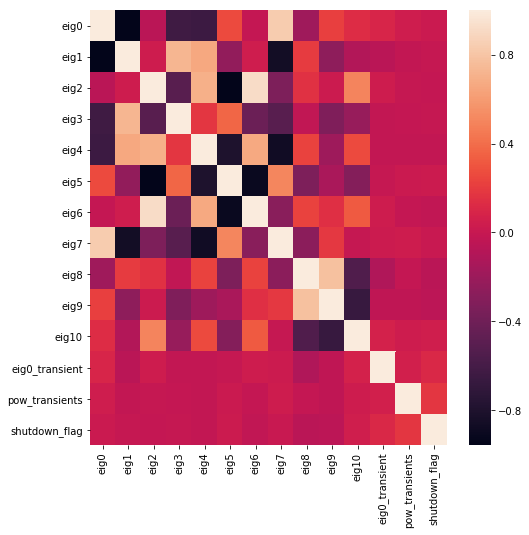

In [258]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,8)
sns.heatmap(eig_poc_df.corr())
plt.show()

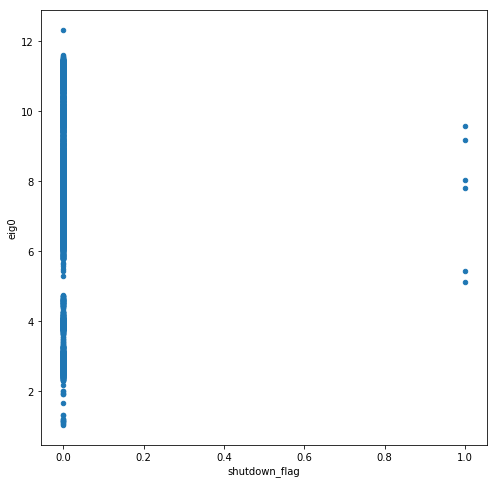

In [259]:
eig_poc_df.plot(kind='scatter',x='shutdown_flag',y='eig0')
plt.show()

In [260]:
eig_poc_df.eig0_transient.value_counts()

0    7536
1      56
Name: eig0_transient, dtype: int64

In [261]:
eig_poc_df.pow_transients.value_counts()

0    7571
1      21
Name: pow_transients, dtype: int64

In [235]:
eig_poc_df[eig_poc_df.pow_transients==1].head(20)

eig0      eig1       eig2      eig3  \
psn timestamp                                                              
46  2017-09-09 12:39:59.999997   8.873570 -0.719908 -10.828660  2.498813   
    2017-09-09 13:30:00.000000   7.698622 -0.793766 -10.897086  1.883387   
    2017-09-09 14:00:00.000003   7.763130 -0.543429 -11.279449  1.004607   
    2017-09-12 08:09:59.999997   8.597314 -0.410457 -11.272176  1.682359   
    2017-09-12 08:40:00.000001   7.759348 -0.943120 -11.118203  1.877742   
    2017-09-23 05:20:00.000002   9.021591 -0.729908 -11.539934  1.807368   
    2017-09-23 07:40:00.000004   7.835172 -0.205053 -11.577156  2.115236   
    2017-09-24 11:49:59.999995   8.029014 -0.402224 -10.307853  1.775609   
    2017-09-30 08:29:59.999996  11.310157 -3.325624  -0.154110 -0.948909   
    2017-09-30 10:10:00.000001   8.541563 -3.238404  -0.808787 -2.223420   
    2017-09-30 12:00:00.000000   1.319130  1.971371  -2.132879 -1.046932   
    2017-09-30 13:19:59.999995   9.304543 -3.919327  -1.200486 -4.128868   
    2017-10-01 14:20:00.000002   1.661000  3.010677  -2.509604 -1.457862   
    2017-10-01 15:10:00.000004   7.796370 -3.321864  -1.402691 -4.098383   
    2017-11-05 09:59:59.999996  12.312802 -3.613202   1.952045  3.921207   
    2017-11-05 10:10:00.000001   3.850122  4.380214  -1.591550  3.017519   
    2017-11-23 13:10:00.000001  11.031614 -4.597946  -0.064207 -0.895061   
    2017-11-24 06:00:00.000000   9.979217 -3.826609  -0.052817 -0.485273   
    2017-11-27 03:10:00.000004   9.917265 -3.209759  -0.433285 -0.027059   
    2017-11-29 13:19:59.999995  10.098028 -4.349851  -0.348451 -1.259375   

                                    eig4       eig5      eig6      eig7  \
psn timestamp                                                             
46  2017-09-09 12:39:59.999997 -2.048205  10.010018 -3.441522  0.888463   
    2017-09-09 13:30:00.000000 -2.787157   9.916818 -3.803903  0.420132   
    2017-09-09 14:00:00.000003 -1.172331   9.773425 -3.312992  1.625029   
    2017-09-12 08:09:59.999997 -3.741201   7.278888 -1.842201  0.607636   
    2017-09-12 08:40:00.000001 -2.648910   7.545251 -1.057882  1.240271   
    2017-09-23 05:20:00.000002 -3.225362   7.156854 -1.024331  0.281512   
    2017-09-23 07:40:00.000004 -1.066919   7.043861 -0.081852  2.106037   
    2017-09-24 11:49:59.999995 -4.852434  10.445597 -3.544636  1.808748   
    2017-09-30 08:29:59.999996 -0.684617   0.745643  2.598821  2.713110   
    2017-09-30 10:10:00.000001  0.276705   0.297440  2.083828  2.431775   
    2017-09-30 12:00:00.000000  2.463206   0.093566  2.408710  0.974679   
    2017-09-30 13:19:59.999995 -0.492514   0.199815  1.929681  2.846041   
    2017-10-01 14:20:00.000002  1.083379  -0.108183  2.134272  1.901007   
    2017-10-01 15:10:00.000004  0.614571   0.411542  1.983051  1.955698   
    2017-11-05 09:59:59.999996 -1.245585   2.065740  4.020409  0.500584   
    2017-11-05 10:10:00.000001  2.557043   0.097884  2.741787 -1.089245   
    2017-11-23 13:10:00.000001 -0.345878   0.730907  1.531061  0.726369   
    2017-11-24 06:00:00.000000 -0.719508   0.928622  2.646130  1.665279   
    2017-11-27 03:10:00.000004  1.163497   0.636487  2.440204  0.546827   
    2017-11-29 13:19:59.999995  0.254350   0.609842  0.647436  0.336156   

                                    eig8      eig9     eig10  eig0_transient  \
psn timestamp                                                                  
46  2017-09-09 12:39:59.999997 -2.185341 -2.094603  4.151951               0   
    2017-09-09 13:30:00.000000 -2.253001 -1.781090  4.279707               0   
    2017-09-09 14:00:00.000003 -2.269671 -2.151261  4.888035               0   
    2017-09-12 08:09:59.999997 -0.484865 -0.289543 -3.205078               1   
    2017-09-12 08:40:00.000001 -0.990250 -0.686858 -2.929472               0   
    2017-09-23 05:20:00.000002 -0.996313 -0.416624 -4.938859               1   
    2017-09-23 07:40:00.000004 -0.360445 -0.713888 -4.211685             

In [206]:
eig_poc_df[eig_poc_df.eig0_transient==1].head(40)

eig0      eig1       eig2      eig3  \
psn timestamp                                                              
46  2017-09-09 10:10:00.000001   5.627633 -1.362622 -10.479907  3.888622   
    2017-09-09 10:19:59.999995   5.792813 -1.692689 -10.540726  4.105538   
    2017-09-09 10:30:00.000000   5.872837 -1.381023 -10.719902  3.969016   
    2017-09-09 10:40:00.000004   5.889028 -1.334736 -10.718865  3.862850   
    2017-09-09 10:49:59.999998   5.795898 -1.308932 -10.598441  3.823045   
    2017-09-12 08:09:59.999997   8.597314 -0.410457 -11.272176  1.682359   
    2017-09-12 08:20:00.000002   8.626907 -0.463257 -11.481911  1.769586   
    2017-09-23 05:20:00.000002   9.021591 -0.729908 -11.539934  1.807368   
    2017-09-23 05:29:59.999996   9.081860 -0.342257 -11.830469  1.639457   
    2017-09-23 05:40:00.000001   9.174746 -0.323163 -11.846275  1.648314   
    2017-09-24 11:49:59.999995   8.029014 -0.402224 -10.307853  1.775609   
    2017-10-01 14:20:00.000002   1.661000  3.010677  -2.509604 -1.457862   
    2017-10-01 14:29:59.999996   1.323997  2.086614  -2.632924 -1.590309   
    2017-10-01 14:40:00.000001   1.161929  1.709499  -2.455108 -1.798800   
    2017-10-01 14:49:59.999995   1.144670  1.962225  -2.679235 -2.160573   
    2017-10-01 15:00:00.000000   1.048898  1.349749  -2.564514 -2.251431   
    2017-11-12 05:40:00.000001   2.425816  3.053591  -1.574318  1.339588   
    2017-11-14 23:20:00.000002   6.647295 -3.199132  -0.575788  0.178346   
    2017-11-15 05:29:59.999996   6.049115 -2.312198  -0.105371  0.071519   
    2017-11-20 06:39:59.999997   4.320857  3.136125  -1.342998  2.141845   
    2017-11-20 06:50:00.000002   4.086159  3.382826  -1.055649  2.070142   
    2017-11-20 06:59:59.999996   4.096193  3.089532  -1.260657  1.977228   
    2017-11-23 13:10:00.000001  11.031614 -4.597946  -0.064207 -0.895061   
    2017-11-23 13:19:59.999995   8.626453  1.232508  -1.037699 -0.204713   
    2017-11-23 13:30:00.000000  11.308371 -4.501613  -0.056233 -0.672624   
    2017-11-23 13:40:00.000004  11.339984 -4.642990  -0.140863 -0.857702   
    2017-11-23 13:49:59.999998  11.173454 -4.270062  -0.213619 -0.849156   
    2017-11-27 03:10:00.000004   9.917265 -3.209759  -0.433285 -0.027059   
    2017-11-27 03:19:59.999998   9.942743 -3.316942  -0.271058 -0.086560   
    2017-11-27 03:30:00.000003   9.563698 -3.270197  -0.114022 -0.022002   
    2017-11-27 03:39:59.999997   9.719563 -3.272623  -0.243701 -0.008195   
    2017-11-27 03:50:00.000002   9.475204 -3.438268  -0.044862 -0.096952   
    2017-11-27 03:59:59.999996   9.311928 -3.428514  -0.029624 -0.167544   
    2017-11-28 09:00:00.000000   5.282103  1.619664  -1.327955  0.655502   
    2017-11-29 10:49:59.999998   2.426343  3.245322  -2.053377  0.757915   
    2017-11-29 11:00:00.000003   2.558792  3.163570  -1.932366  0.916872   
    2017-11-29 11:09:59.999997   2.629909  3.098668  -2.034178  0.836995   
    2017-11-29 11:20:00.000002   2.650059  3.171015  -2.044707  0.807619   
    2017-12-01 12:19:59.999998   5.415866  1.166219  -1.243250  1.447530   
    2017-12-01 12:30:00.000003   3.355388  1.284692  -1.521605  1.623269   

                                    eig4       eig5      eig6      eig7  \
psn timestamp                                                             
46  2017-09-09 10:10:00.000001 -0.881844  13.545843 -5.921799  0.059020   
    2017-09-09 10:19:59.999995 -0.593735  13.650156 -5.748213  0.261054   
    2017-09-09 10:30:00.000000 -0.979905  13.661267 -5.961835  0.291631   
    2017-09-09 10:40:00.000004 -0.943062  13.700755 -5.779393  0.058408   
    2017-09-09 10:49:59.999998 -1.002051  13.673718 -5.704863  0.144923   
    2017-09-12 08:09:59.999997 -3.741201   7.278888 -1.842201  0.607636   
    2017-09-12 08:20:00.000002 -3.630538   7.215137 -2.039657  0.518701   
    2017-09-23 05:20:00.000002 -3.225362   7.156854 -1.024331  0.281512   
    2017-09-23 05:29:59.999996 -3.422135   6.934045 -1.180904  0.211527   
    2017-09-23 05:4

In [199]:
trans_df = eig_poc_df[eig_poc_df.eig0_transient==1]
trans_df.corr()

eig0      eig1      eig2      eig3      eig4      eig5  \
eig0            1.000000 -0.839811 -0.098420  0.010935 -0.580756  0.226213   
eig1           -0.839811  1.000000 -0.003354  0.086452  0.302275 -0.251048   
eig2           -0.098420 -0.003354  1.000000 -0.641683  0.768091 -0.890187   
eig3            0.010935  0.086452 -0.641683  1.000000 -0.378395  0.728865   
eig4           -0.580756  0.302275  0.768091 -0.378395  1.000000 -0.692299   
eig5            0.226213 -0.251048 -0.890187  0.728865 -0.692299  1.000000   
eig6           -0.077565  0.104943  0.869576 -0.693210  0.637911 -0.951610   
eig7            0.360825 -0.484684 -0.220590 -0.353963 -0.398555  0.270031   
eig8           -0.096272  0.242177  0.552737 -0.693389  0.357834 -0.833068   
eig9            0.139233  0.092137  0.490984 -0.581678  0.174885 -0.764686   
eig10          -0.066043 -0.195236 -0.370807  0.591640 -0.078703  0.709044   
eig0_transient       NaN       NaN       NaN       NaN       NaN       NaN   
pow_transients  0.217532 -0.087462 -0.165050 -0.057409 -0.354325  0.085625   
shutdown_flag   0.093183 -0.010380 -0.233097  0.089524 -0.389930  0.249003   

                    eig6      eig7      eig8      eig9     eig10  \
eig0           -0.077565  0.360825 -0.096272  0.139233 -0.066043   
eig1            0.104943 -0.484684  0.242177  0.092137 -0.195236   
eig2            0.869576 -0.220590  0.552737  0.490984 -0.370807   
eig3           -0.693210 -0.353963 -0.693389 -0.581678  0.591640   
eig4            0.637911 -0.398555  0.357834  0.174885 -0.078703   
eig5           -0.951610  0.270031 -0.833068 -0.764686  0.709044   
eig6            1.000000 -0.147125  0.761194  0.748691 -0.698468   
eig7           -0.147125  1.000000 -0.215521 -0.203265  0.091673   
eig8            0.761194 -0.215521  1.000000  0.940982 -0.912549   
eig9            0.748691 -0.203265  0.940982  1.000000 -0.963775   
eig10          -0.698468  0.091673 -0.912549 -0.963775  1.000000   
eig0_transient       NaN       NaN       NaN       NaN       NaN   
pow_transients -0.049871  0.315248  0.039067  0.075404 -0.143884   
shutdown_flag  -0.229231  0.279711 -0.202115 -0.207516  0.088440   

                eig0_transient  pow_transients  shutdown_flag  
eig0                       NaN        0.217532       0.093183  
eig1                       NaN       -0.087462      -0.010380  
eig2                       NaN       -0.165050      -0.233097  
eig3                       NaN       -0.057409       0.089524  
eig4                       NaN       -0.354325      -0.389930  
eig5                       NaN        0.085625       0.249003  
eig6                       NaN       -0.049871      -0.229231  
eig7                       NaN        0.315248       0.279711  
eig8                       NaN        0.039067      -0.202115  
eig9                       NaN        0.075404      -0.207516  
eig10                      NaN       -0.143884       0.088440  
eig0_transient             NaN             NaN            NaN  
pow_transients             NaN        1.000000       0.349927  
shutdown_flag              NaN        0.349927       1.000000

In [200]:
len(trans_df[trans_df.pow_transients==1])/len(trans_df)

0.16279069767441862

In [201]:
trans_df = eig_poc_df[eig_poc_df.pow_transients==1]
trans_df.corr()

eig0      eig1      eig2      eig3      eig4      eig5  \
eig0            1.000000 -0.860607  0.090651  0.039918 -0.451843  0.125218   
eig1           -0.860607  1.000000 -0.337657  0.410264  0.198548  0.163040   
eig2            0.090651 -0.337657  1.000000 -0.483420  0.712848 -0.931280   
eig3            0.039918  0.410264 -0.483420  1.000000 -0.380060  0.572696   
eig4           -0.451843  0.198548  0.712848 -0.380060  1.000000 -0.818495   
eig5            0.125218  0.163040 -0.931280  0.572696 -0.818495  1.000000   
eig6           -0.043059 -0.148733  0.897828 -0.365344  0.746835 -0.940009   
eig7            0.192855 -0.396430 -0.009104 -0.573029 -0.202853  0.014158   
eig8           -0.210243  0.224980  0.384868  0.037772  0.575215 -0.575009   
eig9            0.189595 -0.166028  0.380456  0.002478  0.241927 -0.514569   
eig10          -0.021545 -0.023716  0.037898 -0.031934 -0.005135  0.204406   
eig0_transient -0.085510  0.166087 -0.087864  0.101825 -0.164129  0.021552   
pow_transients       NaN       NaN       NaN       NaN       NaN       NaN   
shutdown_flag  -0.010778 -0.072297 -0.073202 -0.220434 -0.233796  0.144800   

                    eig6      eig7      eig8      eig9     eig10  \
eig0           -0.043059  0.192855 -0.210243  0.189595 -0.021545   
eig1           -0.148733 -0.396430  0.224980 -0.166028 -0.023716   
eig2            0.897828 -0.009104  0.384868  0.380456  0.037898   
eig3           -0.365344 -0.573029  0.037772  0.002478 -0.031934   
eig4            0.746835 -0.202853  0.575215  0.241927 -0.005135   
eig5           -0.940009  0.014158 -0.575009 -0.514569  0.204406   
eig6            1.000000 -0.026690  0.646305  0.613121 -0.310296   
eig7           -0.026690  1.000000 -0.381255 -0.275725  0.059303   
eig8            0.646305 -0.381255  1.000000  0.836252 -0.689629   
eig9            0.613121 -0.275725  0.836252  1.000000 -0.840846   
eig10          -0.310296  0.059303 -0.689629 -0.840846  1.000000   
eig0_transient -0.061404 -0.287454 -0.049629  0.095572 -0.124860   
pow_transients       NaN       NaN       NaN       NaN       NaN   
shutdown_flag  -0.178735  0.236742 -0.353711 -0.357648  0.281691   

                eig0_transient  pow_transients  shutdown_flag  
eig0                 -0.085510             NaN      -0.010778  
eig1                  0.166087             NaN      -0.072297  
eig2                 -0.087864             NaN      -0.073202  
eig3                  0.101825             NaN      -0.220434  
eig4                 -0.164129             NaN      -0.233796  
eig5                  0.021552             NaN       0.144800  
eig6                 -0.061404             NaN      -0.178735  
eig7                 -0.287454             NaN       0.236742  
eig8                 -0.049629             NaN      -0.353711  
eig9                  0.095572             NaN      -0.357648  
eig10                -0.124860             NaN       0.281691  
eig0_transient        1.000000             NaN       0.114708  
pow_transients             NaN             NaN            NaN  
shutdown_flag         0.114708             NaN       1.000000

In [202]:
len(trans_df[trans_df.eig0_transient==1])/len(trans_df)

0.3333333333333333

In [203]:
trans_df = eig_poc_df[(eig_poc_df.pow_transients==1)|(eig_poc_df.eig0_transient==1)]
trans_df.corr()

eig0      eig1      eig2      eig3      eig4      eig5  \
eig0            1.000000 -0.845469 -0.044385 -0.038556 -0.605722  0.201735   
eig1           -0.845469  1.000000 -0.086339  0.238801  0.346606 -0.160819   
eig2           -0.044385 -0.086339  1.000000 -0.543105  0.711127 -0.893756   
eig3           -0.038556  0.238801 -0.543105  1.000000 -0.301710  0.635222   
eig4           -0.605722  0.346606  0.711127 -0.301710  1.000000 -0.696725   
eig5            0.201735 -0.160819 -0.893756  0.635222 -0.696725  1.000000   
eig6           -0.048892  0.039068  0.867875 -0.551056  0.618856 -0.943290   
eig7            0.437695 -0.540674 -0.159905 -0.452610 -0.412797  0.195547   
eig8           -0.092068  0.224293  0.503984 -0.484158  0.361555 -0.781090   
eig9            0.142613  0.042443  0.492048 -0.417992  0.183759 -0.739869   
eig10          -0.078020 -0.139626 -0.314647  0.445057 -0.065998  0.646964   
eig0_transient -0.279042  0.226731  0.064603  0.154335  0.216545 -0.068759   
pow_transients  0.334035 -0.219130 -0.139327 -0.143799 -0.374054  0.102364   
shutdown_flag   0.077986 -0.094674 -0.082709 -0.183823 -0.223926  0.101072   

                    eig6      eig7      eig8      eig9     eig10  \
eig0           -0.048892  0.437695 -0.092068  0.142613 -0.078020   
eig1            0.039068 -0.540674  0.224293  0.042443 -0.139626   
eig2            0.867875 -0.159905  0.503984  0.492048 -0.314647   
eig3           -0.551056 -0.452610 -0.484158 -0.417992  0.445057   
eig4            0.618856 -0.412797  0.361555  0.183759 -0.065998   
eig5           -0.943290  0.195547 -0.781090 -0.739869  0.646964   
eig6            1.000000 -0.079726  0.736181  0.746871 -0.658802   
eig7           -0.079726  1.000000 -0.161757 -0.146112  0.004699   
eig8            0.736181 -0.161757  1.000000  0.927610 -0.898143   
eig9            0.746871 -0.146112  0.927610  1.000000 -0.946633   
eig10          -0.658802  0.004699 -0.898143 -0.946633  1.000000   
eig0_transient  0.000519 -0.498062 -0.069767 -0.019126  0.094529   
pow_transients -0.029997  0.528934  0.076879  0.061654 -0.162871   
shutdown_flag  -0.100317  0.255518 -0.108833 -0.131441  0.048561   

                eig0_transient  pow_transients  shutdown_flag  
eig0                 -0.279042        0.334035       0.077986  
eig1                  0.226731       -0.219130      -0.094674  
eig2                  0.064603       -0.139327      -0.082709  
eig3                  0.154335       -0.143799      -0.183823  
eig4                  0.216545       -0.374054      -0.223926  
eig5                 -0.068759        0.102364       0.101072  
eig6                  0.000519       -0.029997      -0.100317  
eig7                 -0.498062        0.528934       0.255518  
eig8                 -0.069767        0.076879      -0.108833  
eig9                 -0.019126        0.061654      -0.131441  
eig10                 0.094529       -0.162871       0.048561  
eig0_transient        1.000000       -0.747087      -0.112695  
pow_transients       -0.747087        1.000000       0.249675  
shutdown_flag        -0.112695        0.249675       1.000000

In [204]:
trans_df = eig_poc_df[(eig_poc_df.pow_transients==1)&(eig_poc_df.eig0_transient==1)]
trans_df.corr()

eig0      eig1      eig2      eig3      eig4      eig5  \
eig0            1.000000 -0.926830 -0.127898  0.267619 -0.361062  0.294710   
eig1           -0.926830  1.000000 -0.215011  0.093220  0.073152  0.018332   
eig2           -0.127898 -0.215011  1.000000 -0.734121  0.914671 -0.929532   
eig3            0.267619  0.093220 -0.734121  1.000000 -0.635920  0.736605   
eig4           -0.361062  0.073152  0.914671 -0.635920  1.000000 -0.976713   
eig5            0.294710  0.018332 -0.929532  0.736605 -0.976713  1.000000   
eig6           -0.271826 -0.012696  0.902910 -0.646163  0.987738 -0.986574   
eig7           -0.200348  0.118023 -0.209015 -0.385478 -0.356580  0.301894   
eig8           -0.134472  0.098492  0.283726 -0.166652  0.538140 -0.573121   
eig9            0.243291 -0.192618  0.032039  0.038318  0.210224 -0.290189   
eig10          -0.137544 -0.009123  0.369428 -0.173102  0.146522 -0.064703   
eig0_transient       NaN       NaN       NaN       NaN       NaN       NaN   
pow_transients       NaN       NaN       NaN       NaN       NaN       NaN   
shutdown_flag   0.050239  0.058327 -0.405721  0.366960 -0.598638  0.671396   

                    eig6      eig7      eig8      eig9     eig10  \
eig0           -0.271826 -0.200348 -0.134472  0.243291 -0.137544   
eig1           -0.012696  0.118023  0.098492 -0.192618 -0.009123   
eig2            0.902910 -0.209015  0.283726  0.032039  0.369428   
eig3           -0.646163 -0.385478 -0.166652  0.038318 -0.173102   
eig4            0.987738 -0.356580  0.538140  0.210224  0.146522   
eig5           -0.986574  0.301894 -0.573121 -0.290189 -0.064703   
eig6            1.000000 -0.400351  0.611181  0.332369  0.021930   
eig7           -0.400351  1.000000 -0.587266 -0.614864  0.321937   
eig8            0.611181 -0.587266  1.000000  0.888319 -0.670895   
eig9            0.332369 -0.614864  0.888319  1.000000 -0.860668   
eig10           0.021930  0.321937 -0.670895 -0.860668  1.000000   
eig0_transient       NaN       NaN       NaN       NaN       NaN   
pow_transients       NaN       NaN       NaN       NaN       NaN   
shutdown_flag  -0.695228  0.496568 -0.952731 -0.882460  0.676987   

                eig0_transient  pow_transients  shutdown_flag  
eig0                       NaN             NaN       0.050239  
eig1                       NaN             NaN       0.058327  
eig2                       NaN             NaN      -0.405721  
eig3                       NaN             NaN       0.366960  
eig4                       NaN             NaN      -0.598638  
eig5                       NaN             NaN       0.671396  
eig6                       NaN             NaN      -0.695228  
eig7                       NaN             NaN       0.496568  
eig8                       NaN             NaN      -0.952731  
eig9                       NaN             NaN      -0.882460  
eig10                      NaN             NaN       0.676987  
eig0_transient             NaN             NaN            NaN  
pow_transients             NaN             NaN            NaN  
shutdown_flag              NaN             NaN       1.000000

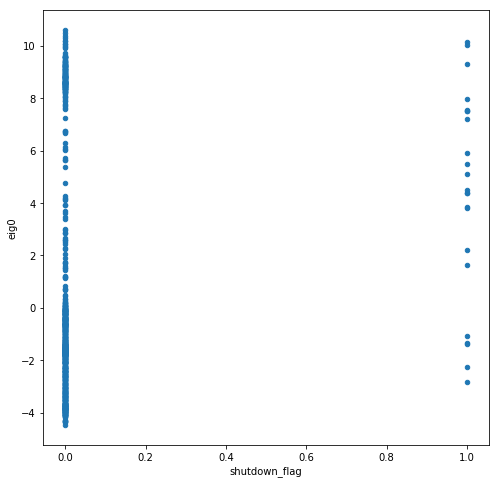

In [89]:
trans_df.plot(kind='scatter',x='shutdown_flag',y='eig0')
plt.show()